# setup

* I struggled with the installation witb GPU support, only able to fix from: https://gemini.google.com/app/f3ec74b59f92f56f

* This Gemini thread helpped me setup the dual CPU/GPU support: https://g.co/gemini/share/6c4f43639380

In [1]:
import os
import torch
import time
import numpy as np
import pandas as pd
import math
from collections import Counter
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm # For a nice progress bar

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive/',force_remount=True)

path = '/content/drive/MyDrive/dev/'

Mounted at /content/drive/


In [3]:
if torch.cuda.is_available():
    print(f"CUDA version: {torch.version.cuda}")

CUDA version: 12.4


In [4]:
if torch.cuda.is_available():
    !nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [5]:
if torch.cuda.is_available():
    !nvidia-smi

Sat Jul 12 18:40:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   53C    P8             15W /   72W |       3MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
# Uninstall any existing version to ensure a clean slate
print("Uninstalling existing llama-cpp-python to ensure a clean install...")
!pip uninstall -y llama-cpp-python

Uninstalling existing llama-cpp-python to ensure a clean install...


In [7]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    print("GPU detected. Installing the CUDA-enabled version of llama-cpp-python ...")
    # This command will install the version compatible with the Colab GPU's CUDA version
    # The --no-cache-dir flag helps ensure a fresh download
    !pip install llama-cpp-python --extra-index-url https://abetlen.github.io/llama-cpp-python/whl/cu124 --no-cache-dir
else:
    print("No GPU detected. Installing the CPU-only version of llama-cpp-python ...")
    # This is the standard command for a CPU-only installation
    !pip install llama-cpp-python

GPU detected. Installing the CUDA-enabled version of llama-cpp-python ...
Looking in indexes: https://pypi.org/simple, https://abetlen.github.io/llama-cpp-python/whl/cu124
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 MB 31.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 236.3 MB/s eta 0:00:00


In [8]:
# Verify the installation
try:
    from llama_cpp import Llama, LlamaGrammar
    print("llama-cpp-python imported successfully!")
except Exception as e:
    print(f"Error importing llama-cpp-python: {e}")

llama-cpp-python imported successfully!


# models

## n_gpu_layers

* This Notebook is just to test running various quantized TinyLlama models

* As a result, we will either use either n_gpu_layers = 0 (for running on CPU only) or n_gpu_layers = 33 (33 GPU layers)

* Refer to the Gemini explanation below in order to optimize n_gpu_layers when running the code for getting results

In [9]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    n_gpu_layers = 33 # GPU
else:
    n_gpu_layers = 0 # CPU

https://g.co/gemini/share/1de12d982e5f

That's an excellent and very important question for getting the best performance out of your models. Setting `n_gpu_layers` is the primary way you control the balance between CPU and GPU work.

Here’s a breakdown of what it means and how to find the optimal value for your specific system.

### What `n_gpu_layers` Does

This parameter determines how many layers of the neural network are "offloaded" to your GPU's VRAM.

  * **CPU:** Your computer's main processor. It has access to a large amount of slower system RAM.
  * **GPU:** Your graphics card. It has a smaller amount of very fast video RAM (VRAM) and is designed for the massive parallel calculations that LLMs require.

**The trade-off is simple:**

  * **More layers on the GPU (`n_gpu_layers` is high):** Inference (generating text) is much faster.
  * **Fewer layers on the GPU (`n_gpu_layers` is low):** More work is done on the slower CPU, but it uses less of your precious VRAM.

The "optimal" value is therefore: **The maximum number of layers you can fit into your GPU's VRAM without causing errors, while leaving a small buffer for your operating system.**

-----

### How to Find the Optimal Value: A Practical Guide

The best way to find the perfect number is through a bit of experimentation. Here is a simple, effective process:

#### Step 1: Know Your Total VRAM

First, check how much VRAM your GPU has.

  * **On Windows:** Open the Task Manager, go to the "Performance" tab, and click on your GPU. Look for "Dedicated GPU Memory".
  * **On Linux (with NVIDIA):** Open a terminal and run the command `nvidia-smi`. It will show you your GPU's total memory (e.g., `8192MiB`).

#### Step 2: Start High and Let the Model Tell You

You don't need to guess the number of layers. The easiest method is to set `n_gpu_layers` to a very high number. The `llama-cpp-python` library is smart enough to only offload as many layers as it can actually fit.

Modify your model loading code like this:

```python
from llama_cpp import Llama

llm = Llama(
    model_path="/path/to/your/model.gguf",
    # Set a very high number to offload as many layers as possible
    n_gpu_layers=999,  # <--- START WITH A HIGH NUMBER
    n_ctx=2048,
    verbose=True  # <--- Set to True to see the loading output
)
```

#### Step 3: Observe the Output

When you run this code, `llama.cpp` will print detailed information as it loads the model. Look for a line that looks like this:

```
llama_model_load_internal: offloaded 33 of 33 layers to GPU
```

or

```
llm_load_tensors: offloaded 33/33 layers to GPU
```

**That number is your answer.** In this example, the model has 33 layers, and all of them fit into your VRAM. Your optimal `n_gpu_layers` is **33**. You can then set `n_gpu_layers=33` in your code for future runs to be precise.

#### What If It Crashes?

If you set the number too high manually and your system becomes unstable or the program crashes with a "CUDA out of memory" error, it means you've exceeded your VRAM. In that case, simply lower the number and try again. For example, if `n_gpu_layers=33` crashes, try `30`, then `28`, until you find a stable number.

**Pro Tip:** Often, the last one or two layers of a model can be disproportionately large. If you find that offloading all layers works but your computer feels sluggish, try reducing the number by 1 or 2 (e.g., `n_gpu_layers=31` instead of `33`). This leaves a bit more VRAM for your operating system and can lead to a smoother overall experience with a negligible impact on performance.
That's an excellent and very practical question. Finding the optimal `n_gpu_layers` is the key to getting the best performance out of your hardware. Here’s a breakdown of what it means and how to find the best value for your specific setup.

### What `n_gpu_layers` Does

This parameter controls how many layers of the model are "offloaded" from your system's RAM to the GPU's dedicated, high-speed VRAM.

  * **`n_gpu_layers = 0`**: The entire model runs on your CPU. This is the slowest option but uses the least VRAM.
  * **`n_gpu_layers > 0`**: The specified number of layers are moved to the GPU. Since GPUs are massively parallel, they can process these layers much faster than a CPU, leading to a significant speedup in generating tokens.
  * **The Goal**: Offload as many layers as possible to the GPU without running out of VRAM.

### The Trade-Off: Speed vs. VRAM

The main limiting factor is your GPU's VRAM capacity. Each layer you offload consumes a chunk of VRAM. If you try to offload more layers than your VRAM can hold, the program will crash with an out-of-memory error.

The performance gain is not linear. The bulk of the computation happens in the middle layers. Offloading the first few layers gives a huge speed boost. Continuing to offload more layers gives diminishing returns, but is still faster.

### How to Find the Optimal Value: A Simple Experiment

The best way to find the ideal number is to test it empirically.

**Step 1: Start High**

The easiest way to start is to set `n_gpu_layers` to a very large number, like `-1` or `999`. The `llama-cpp-python` library is smart enough to know this means "offload as many layers as you possibly can".

```python
# Try to offload all layers
llm = Llama(
    model_path="path/to/your/model.gguf",
    n_gpu_layers=-1, # -1 means "all possible layers"
    verbose=True # Set to True to see the loading output
)
```

**Step 2: Watch the Output During Loading**

When the model loads with `verbose=True`, it will print detailed information. Look for a line that looks like this:

`llama_model_load_internal: offloaded 33 of 33 layers to GPU`

This tells you the maximum number of layers the model has (`33` in this case) and how many it successfully moved to the GPU. **The number it successfully offloaded is your practical maximum.**

**Step 3: Monitor Your VRAM**

While the model is loaded, open your system's GPU monitoring tool:

  * **NVIDIA GPUs**: Use `nvidia-smi` in your command line/terminal.
  * **AMD GPUs**: Use `radeontop` or the monitoring utility in your driver software.
  * **Windows**: The Performance tab in the Task Manager (select your GPU).

Check how much VRAM is being used. If it's very close to the maximum (e.g., 7.8GB / 8.0GB), you are at the limit.

**Step 4: Fine-Tune if Necessary**

  * **If it crashes with an "out of memory" error:** Your GPU can't handle all the layers. Reduce the number. If the model has 33 layers, try `n_gpu_layers=28`, then `25`, and so on, until it loads successfully.
  * **If it loads but VRAM is maxed out:** You've found a good value. You might want to reduce it by 1 or 2 layers (`n_gpu_layers=31` instead of `33`) just to leave a little breathing room for your operating system or other applications, which can prevent stuttering.

**In summary, the ideal `n_gpu_layers` is the highest number you can set without running out of VRAM.** The "set it to -1 and see what happens" method is the quickest way to find that number.


## tinyllama-1.1b-chat-v1.0.Q2_K.gguf

https://g.co/gemini/share/5e6bc8594d7d



In [ ]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q2_K.gguf"
generator_q2_k = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [ ]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q2_k.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


## tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf

In [ ]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q4_K_M.gguf"
generator_q4_k_m = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [ ]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q4_k_m.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


## tinyllama-1.1b-chat-v1.0.Q6_K.gguf

In [ ]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q6_K.gguf"
generator_q6_k = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [ ]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q6_k.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


## tinyllama-1.1b-chat-v1.0.Q8_0.gguf

In [10]:
model_path = path+".models/tinyllama-1.1b-chat-v1.0.Q8_0.gguf"
generator_q8_0 = Llama(
    model_path=model_path,
    chat_format="disabled",  # This prevents the model from wrapping input in chat templates
    n_ctx=2048,
    n_threads=2,
    n_gpu_layers=n_gpu_layers,
    logits_all=True,
    verbose=False,
)

llama_kv_cache_unified: LLAMA_SET_ROWS=0, using old ggml_cpy() method for backwards compatibility


In [11]:
# Check the number of layers offloaded to the GPU
offloaded_layers = generator_q8_0.model_params.n_gpu_layers
print(f"✅ Successfully offloaded {offloaded_layers} layers to the GPU")

✅ Successfully offloaded 33 layers to the GPU


# experiments

## data

In [12]:
# Load World M2 (wm2) and Bitcoin (btc) data
data_path = path+"sapheneia/github/sapheneia/data/"
btc  = pd.read_csv(data_path+"btc.csv")
wm2 = pd.read_csv(data_path+"wm2.csv")

In [13]:
# Define the horizon for computation of changes in each time-series
# Given the use case of BTC and WM2 and that WM2 is given in weeks, the number of periods for horizon will be in weeks
changes_horizon = 1

In [14]:
# Convert 'Date' column in btc to datetime objects
btc['Date'] = pd.to_datetime(btc['Date'])

# Convert 'observation_date' column in wm2 to datetime objects
wm2['observation_date'] = pd.to_datetime(wm2['observation_date'])

# Merge the two dataframes on the date columns
data = pd.merge(btc, wm2, left_on='Date', right_on='observation_date', how='inner')
data = data[['Date','Close','WM2NS']]
data = data.rename(columns={'Date': 'date','Close': 'btc','WM2NS': 'wm2'})

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2
0,2014-04-21,495.16,11355.4
1,2014-04-28,441.92,11231.2
2,2014-05-05,430.87,11285.3
3,2014-05-12,438.21,11286.0
4,2014-05-19,443.90,11278.4


In [15]:
# prompt: Using dataframe data: Compute a column for each btc and wm2 with the changes from one period to another. Change here is defined as log(x_2,x_1) where x_2 is the value of the column in a period ahead of the value x_1, where the number of periods between x_2 and x_1 is defined by a parameter horizon. Start with the first x_1 as the first period in the dataframe.

# Calculate the log change for 'btc'
data['btc_change'] = np.log(data['btc'] / data['btc'].shift(changes_horizon))

# Calculate the log change for 'wm2'
data['wm2_change'] = np.log(data['wm2'] / data['wm2'].shift(changes_horizon))

# prompt: Using dataframe data: Now given btc_change and wm2_change, first clean up rows NaN.

# Clean up rows with NaN values in 'btc_change' or 'wm2_change'
data.dropna(subset=['btc_change', 'wm2_change'], inplace=True)

# Round btc_change and wm2_change to 4 decimal places
data['btc_change'] = data['btc_change'].round(4)
data['wm2_change'] = data['wm2_change'].round(4)

# Sort by date to ensure calculations are in chronological order
data.sort_values(by='date', inplace=True)

# Display the first few rows of the merged dataframe
display(data.head())

,date,btc,wm2,btc_change,wm2_change
1,2014-04-28,441.92,11231.2,-0.1138,-0.0110
2,2014-05-05,430.87,11285.3,-0.0253,0.0048
3,2014-05-12,438.21,11286.0,0.0169,0.0001
4,2014-05-19,443.90,11278.4,0.0129,-0.0007
5,2014-05-26,582.01,11251.3,0.2709,-0.0024


In [16]:
series_a = data['wm2'].tolist()
print(series_a)

[11231.2, 11285.3, 11286.0, 11278.4, 11251.3, 11345.1, 11363.4, 11380.3, 11290.0, 11343.1, 11426.4, 11423.3, 11393.9, 11364.3, 11461.6, 11431.4, 11442.5, 11383.5, 11442.4, 11495.9, 11516.0, 11436.8, 11451.4, 11556.2, 11556.7, 11570.3, 11525.4, 11574.6, 11621.4, 11643.2, 11580.5, 11668.9, 11725.5, 11765.8, 11784.7, 11799.9, 11830.1, 11807.0, 11762.9, 11687.2, 11788.6, 11822.0, 11864.8, 11850.4, 11927.6, 11956.1, 11988.2, 11933.3, 11970.5, 12122.2, 12100.8, 12043.8, 11862.5, 11907.6, 11914.4, 11928.6, 11882.7, 11941.8, 11980.2, 11996.0, 11940.3, 11958.2, 12091.4, 12045.8, 12010.7, 11960.7, 12045.2, 12073.7, 12107.6, 12051.8, 12087.0, 12170.8, 12196.8, 12142.7, 12084.0, 12180.8, 12170.7, 12177.6, 12143.2, 12260.4, 12303.0, 12334.7, 12281.7, 12316.0, 12380.4, 12417.7, 12472.4, 12464.1, 12496.9, 12552.2, 12508.6, 12423.3, 12466.0, 12478.4, 12545.5, 12532.0, 12559.9, 12658.1, 12681.9, 12684.6, 12735.0, 12825.3, 12839.9, 12850.9, 12693.8, 12710.3, 12731.5, 12748.3, 12701.8, 12689.6, 12802.7, 

In [17]:
series_b = data['btc'].tolist()
print(series_b)

[441.92, 430.87, 438.21, 443.9, 582.01, 655.49, 644.35, 599.08, 591.17, 635.14, 613.6, 618.32, 625.13, 587.93, 592.77, 575.89, 462.18, 502.93, 477.19, 475.69, 477.71, 404.09, 376.77, 331.55, 387.32, 380.39, 350.09, 324.24, 367.15, 384.69, 378.85, 378.61, 364.95, 345.37, 330.84, 314.12, 274.84, 269.33, 215.87, 269.18, 238.86, 220.34, 235.83, 238.82, 273.75, 290.02, 290.41, 265.46, 246.79, 254.97, 223.59, 224.24, 228.96, 238.97, 241.81, 232.64, 237.41, 223.14, 228.57, 237.0, 247.46, 256.97, 269.08, 290.35, 277.68, 293.01, 281.58, 263.3, 257.13, 211.43, 229.47, 239.58, 229.91, 226.33, 238.87, 240.15, 245.35, 263.82, 285.15, 359.28, 380.22, 330.21, 322.12, 377.97, 394.28, 442.0, 437.59, 421.76, 433.32, 447.72, 384.4, 392.76, 372.18, 372.63, 401.07, 437.79, 436.21, 414.87, 414.31, 411.11, 422.21, 419.33, 421.43, 427.69, 461.73, 444.18, 460.44, 454.87, 443.69, 532.26, 583.58, 700.07, 733.97, 644.66, 675.16, 646.71, 670.38, 654.0, 607.0, 589.24, 566.95, 587.47, 574.23, 605.76, 607.98, 609.85,

In [18]:
len(data)

576

## simulation #1

In [92]:
# Define the grammar in GBNF format
# This grammar allows for a sequence of numbers (integers or decimals) separated by commas
# https://g.co/gemini/share/938d5c086f74
# gbnf_grammar_str = r'''
# root   ::= sequence
# sequence ::= number ("," number)*
# number ::= ("-")? ([0-9]+ | [0-9]+ "." [0-9]+)
# '''

# Stricter GBNF Grammar for numbers between 0 and 1
# This forces the model to generate numbers like "0.1234"
# https://g.co/gemini/share/a6f8d45d23c5
gbnf_grammar_str = r'''
root   ::= sequence
sequence ::= number ("," number)*
number ::= "0" "." [0-9]+
'''

try:
    grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict grammar parsed successfully")
    print(grammar)
except Exception as e:
    print(f"Error parsing grammar: {e}")
    grammar = None

Strict grammar parsed successfully


### experiment 1: interleaved sequence with lag=0

In [93]:
generator_model = generator_q8_0
grammar_obj = grammar

In [176]:
horizon = 10
num_simulations = 100
temperature = 0.9
start_index = 550
lookback = 52

In [137]:
# --- Sigmoid and Inverse Sigmoid (Logit) Functions (Unchanged) ---
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [138]:
# --- NEW: Sigmoid and Inverse Sigmoid (Logit) Functions ---
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def inverse_sigmoid(y):
    # Also known as the logit function
    # We add a small epsilon to avoid log(0) for values close to 0 or 1
    epsilon = 1e-9
    y = np.clip(y, epsilon, 1 - epsilon)
    return np.log(y / (1 - y))

In [164]:
def simulate_future_trajectories(
    prompt_text,
    generator_model,
    grammar_obj,
    horizon=10,
    num_simulations=100,
    temperature=0.5
):
    """
    Runs N simulations to generate multiple full future trajectories.
    """

    # sequence = ['%.2f' % x for x in series]
    # prompt_text = ",".join(sequence)

    if not grammar_obj or not generator_model:
        return None

    all_trajectories = []
    print(f"\n--- Running {num_simulations} simulations for a horizon of {horizon} steps ---")

    # Use tqdm for a progress bar
    for _ in tqdm(range(num_simulations), desc="Simulating Trajectories"):
        response = generator_model(
            prompt_text,
            max_tokens=horizon * 5, # Generate enough tokens to get `horizon` numbers
            temperature=temperature,
            grammar=grammar_obj,
            stop=["\n"]
        )

        generated_text = response['choices'][0]['text']

        # Find all numbers in the generated string
        numbers_str = re.findall(r'-?\d+\.\d+|-?\d+', generated_text)

        # Convert to float and take only up to the desired horizon
        trajectory = [float(n) for n in numbers_str[:horizon]]

        # Ensure the trajectory has the correct length by padding if necessary
        while len(trajectory) < horizon:
            trajectory.append(trajectory[-1]) # Simple padding with the last value

        all_trajectories.append(trajectory)

    return np.array(all_trajectories)


In [163]:
# series = (data['btc']/100.).tolist()
# series = series[400:(len(series)-horizon)]

historical_data = data['btc'].tolist()[-(lookback+horizon):]
historical_data = np.array(historical_data[:-horizon])
# historical_data = np.array(historical_data[400:(len(historical_data)-horizon)])
len(historical_data)

52

In [165]:
from sklearn.preprocessing import StandardScaler

# --- 1. STANDARDIZE AND APPLY SIGMOID ---
historical_data_reshaped = historical_data.reshape(-1, 1)

# Fit a StandardScaler to the raw data
scaler = StandardScaler()
scaler.fit(historical_data_reshaped)

# Standardize the data (mean=0, std=1)
standardized_data = scaler.transform(historical_data_reshaped)

# Apply the sigmoid function to map to the [0, 1] range
normalized_data = sigmoid(standardized_data).flatten()

print(f"Original first value: {historical_data[0]:.2f}, Sigmoid-Normalized: {normalized_data[0]:.4f}")
print(f"Original last value:  {historical_data[-1]:.2f}, Sigmoid-Normalized: {normalized_data[-1]:.4f}")

Original first value: 68338.64, Sigmoid-Normalized: 0.3994
Original last value:  91536.97, Sigmoid-Normalized: 0.7499


In [166]:
# --- 2. CREATE PROMPT WITH NORMALIZED DATA ---
# Format normalized data as strings with a few decimal places
prompt_data = ['%.4f' % x for x in normalized_data]
prompt = ",".join(prompt_data) + ","
prompt

'0.3994,0.4590,0.3880,0.4238,0.4205,0.4515,0.3261,0.3765,0.3319,0.3221,0.3188,0.4483,0.4158,0.4066,0.4177,0.3708,0.2825,0.3175,0.2381,0.3452,0.3874,0.3754,0.2080,0.2707,0.2720,0.3177,0.2680,0.2422,0.2562,0.3246,0.3242,0.3087,0.3646,0.3842,0.4243,0.3912,0.7146,0.7373,0.7676,0.7988,0.8138,0.8853,0.7872,0.7632,0.8577,0.7845,0.8566,0.8560,0.8510,0.8150,0.7981,0.7499,'

In [177]:
# --- 3. RUN SIMULATION ---
# The model will now see and generate numbers between 0 and 1
normalized_trajectories = simulate_future_trajectories(
    prompt,
    generator_model,
    grammar_obj,
    horizon=horizon,
    num_simulations=num_simulations,
    temperature=temperature # A slightly lower temp can help with noisy data
)


--- Running 100 simulations for a horizon of 10 steps ---


Simulating Trajectories: 100%|██████████| 100/100 [00:58<00:00,  1.70it/s]


In [168]:
def plot_forecast_cloud(historical_data, forecast_trajectories):
    """
    Visualizes historical data and a cloud of forecasted trajectories,
    ensuring the forecast is connected to the historical data.
    """
    # --- Calculate Quantiles ---
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    # --- THE CRITICAL FIX IS HERE ---
    # Get the last point of the historical data to anchor the forecast
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    # Adjust the forecast time axis to start from the last historical point
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))
    # --- END OF FIX ---

    # --- Create the Plot ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Define the historical time axis
    historical_time = np.arange(len(historical_data))

    # Plot historical data
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)

    # Plot the median forecast (50th percentile)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)

    # Create the "Cloud" using fill_between
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    # --- Final Touches ---
    plt.title('Probabilistic Time Series Forecast', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

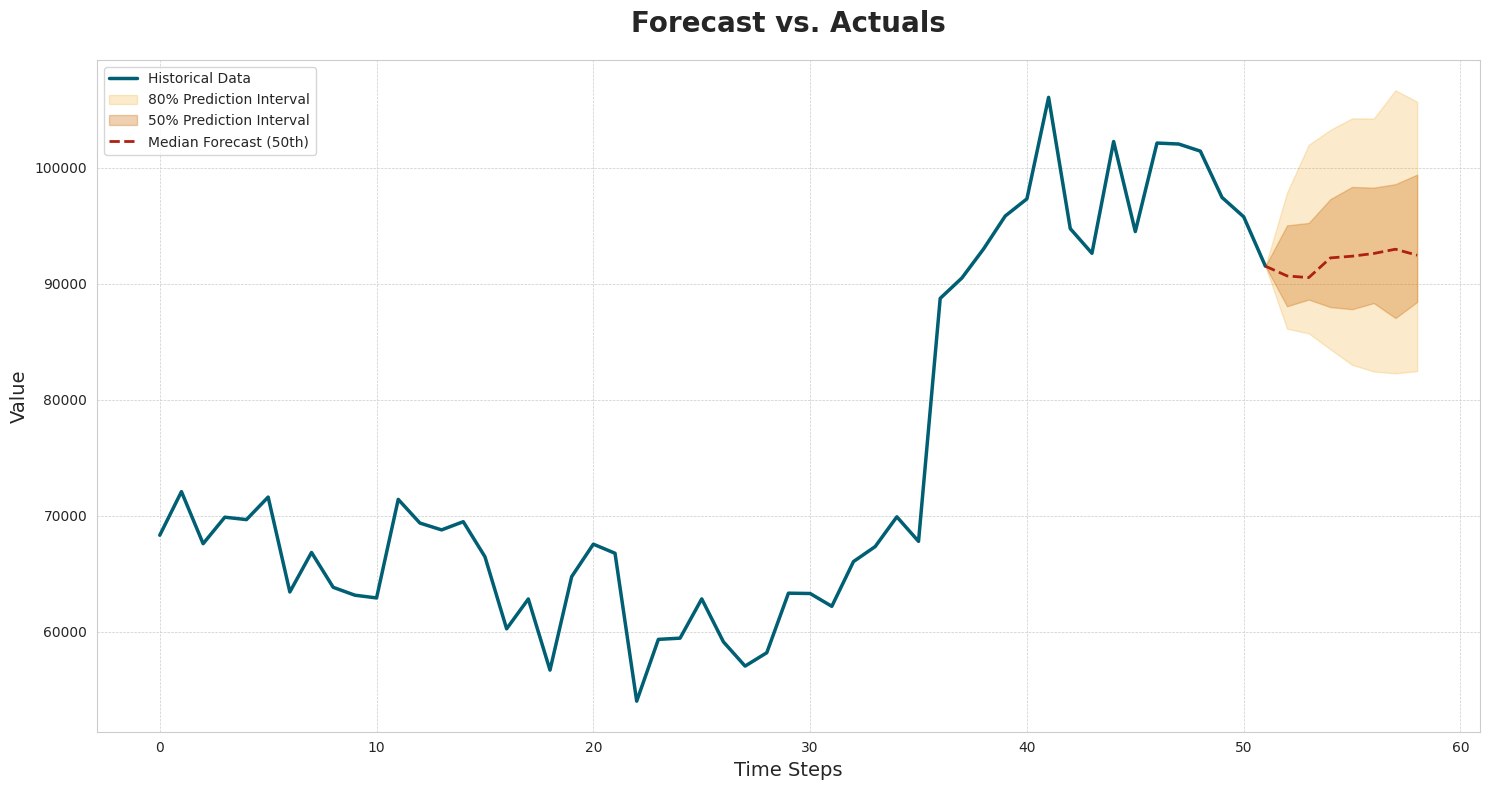

In [178]:
trajectories = normalized_trajectories[:, :7]

# --- 4. INVERSE TRANSFORM THE RESULTS ---
if trajectories is not None and trajectories.size > 0:
    # Step 4a: Apply the inverse sigmoid (logit) function to get back to standardized scale
    inverse_sigmoid_trajectories = inverse_sigmoid(trajectories)

    # Step 4b: Use the scaler to inverse transform back to the original data scale
    rescaled_trajectories = scaler.inverse_transform(inverse_sigmoid_trajectories)

    # --- 5. PLOT THE FINAL, RECONSTRUCTED RESULTS ---
    plot_forecast_cloud(historical_data, rescaled_trajectories)
else:
    print("Simulation did not produce valid trajectories.")

In [172]:
# --- EDITED PLOTTING FUNCTION ---
def plot_forecast_cloud(historical_data, forecast_trajectories, actual_future_data=None):
    """
    Visualizes historical data, a forecast cloud, and the actual future data for comparison.
    """
    if forecast_trajectories is None or forecast_trajectories.size == 0:
        print("No forecast data to plot.")
        return

    # Calculate quantiles for the forecast cloud
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    # Get the last point of the historical data to anchor the forecast
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series for a connected plot
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    # --- Create the time axes ---
    historical_time = np.arange(len(historical_data))
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))

    # --- Create the Plot ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Plot historical data
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)

    # Plot the forecast cloud
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    # Plot the median forecast
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)

    # --- NEW: Plot the actual future data for comparison ---
    if actual_future_data is not None and len(actual_future_data) > 0:
        # Create a time axis for the actuals that starts where the history ends
        actual_time = np.arange(last_hist_time, last_hist_time + len(actual_future_data) + 1)
        # Prepend the last historical point to connect the lines seamlessly
        actual_plot_data = np.insert(actual_future_data, 0, last_hist_value)

        plt.plot(actual_time, actual_plot_data, color='green', marker='o', markersize=5, linestyle='-', label='Actual Future Data', zorder=4)
    # --- END OF NEW CODE ---

    # --- Final Touches ---
    plt.title('Forecast vs. Actuals', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [173]:
actual_future_data = data['btc'].tolist()
actual_future_data = actual_future_data[-horizon:-3]
actual_future_data

[86158.953, 78561.617, 84025.117, 87520.477, 82539.523, 79143.063, 84575.75]

In [174]:
historical_data

array([ 68338.641,  72095.859,  67609.438,  69892.258,  69686.367,
        71629.359,  63447.27 ,  66854.242,  63847.539,  63168.441,
        62932.289,  71430.227,  69386.828,  68799.602,  69505.57 ,
        66481.727,  60270.949,  62841.27 ,  56709.762,  64765.551,
        67567.711,  66782.781,  54031.82 ,  59360.891,  59464.41 ,
        62850.27 ,  59147.801,  57056.309,  58210.012,  63341.969,
        63314.809,  62209.84 ,  66068.25 ,  67358.141,  69925.828,
        67811.953,  88758.313,  90514.828,  93019.383,  95859.75 ,
        97338.344, 106089.203,  94771.641,  92646.211, 102282.203,
        94517.656, 102148.742, 102065.719, 101451.281,  97458.594,
        95790.313,  91536.969])

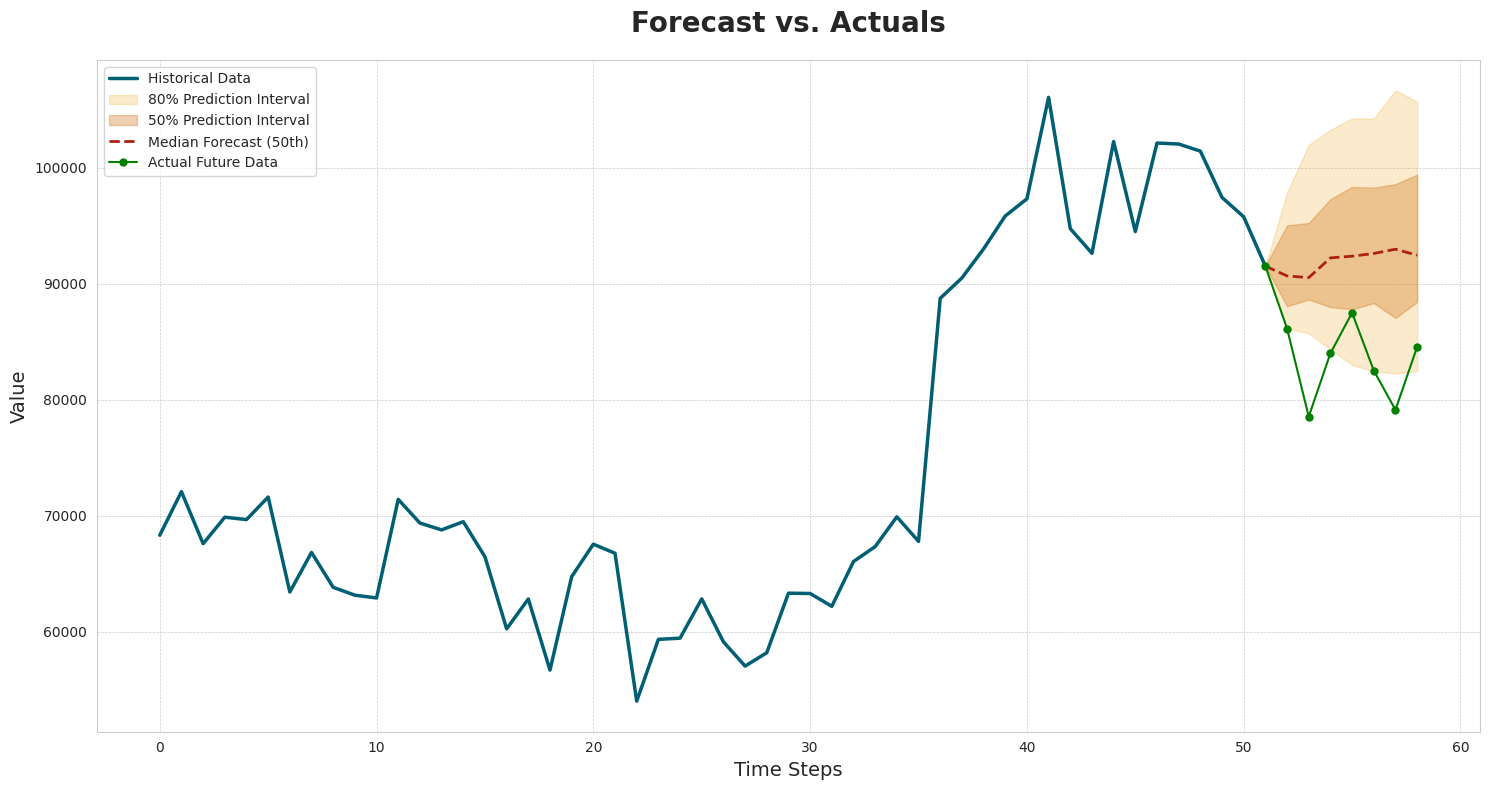

In [179]:
trajectories = normalized_trajectories[:, :7]

# --- 4. INVERSE TRANSFORM THE RESULTS ---
if trajectories is not None and trajectories.size > 0:
    # Step 4a: Apply the inverse sigmoid (logit) function to get back to standardized scale
    inverse_sigmoid_trajectories = inverse_sigmoid(trajectories)

    # Step 4b: Use the scaler to inverse transform back to the original data scale
    rescaled_trajectories = scaler.inverse_transform(inverse_sigmoid_trajectories)

    # --- 5. PLOT THE FINAL, RECONSTRUCTED RESULTS ---
    plot_forecast_cloud(historical_data, rescaled_trajectories, actual_future_data)
else:
    print("Simulation did not produce valid trajectories.")

In [144]:
normalized_trajectories_previous = normalized_trajectories

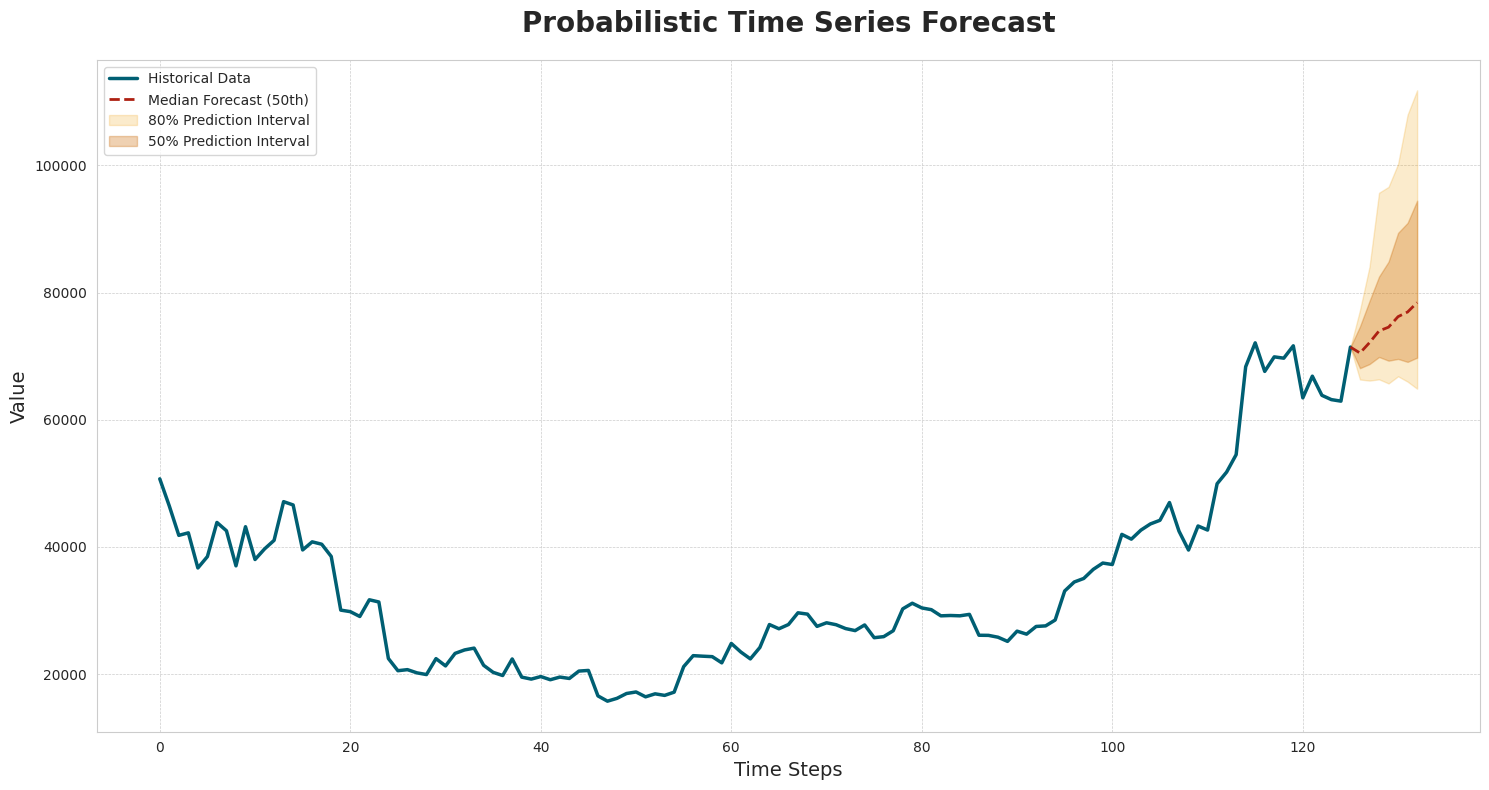

In [111]:
trajectories = normalized_trajectories[:, :7]

# --- 4. INVERSE TRANSFORM THE RESULTS ---
if trajectories is not None and trajectories.size > 0:
    # Step 4a: Apply the inverse sigmoid (logit) function to get back to standardized scale
    inverse_sigmoid_trajectories = inverse_sigmoid(trajectories)

    # Step 4b: Use the scaler to inverse transform back to the original data scale
    rescaled_trajectories = scaler.inverse_transform(inverse_sigmoid_trajectories)

    # --- 5. PLOT THE FINAL, RECONSTRUCTED RESULTS ---
    plot_forecast_cloud(historical_data, rescaled_trajectories)
else:
    print("Simulation did not produce valid trajectories.")

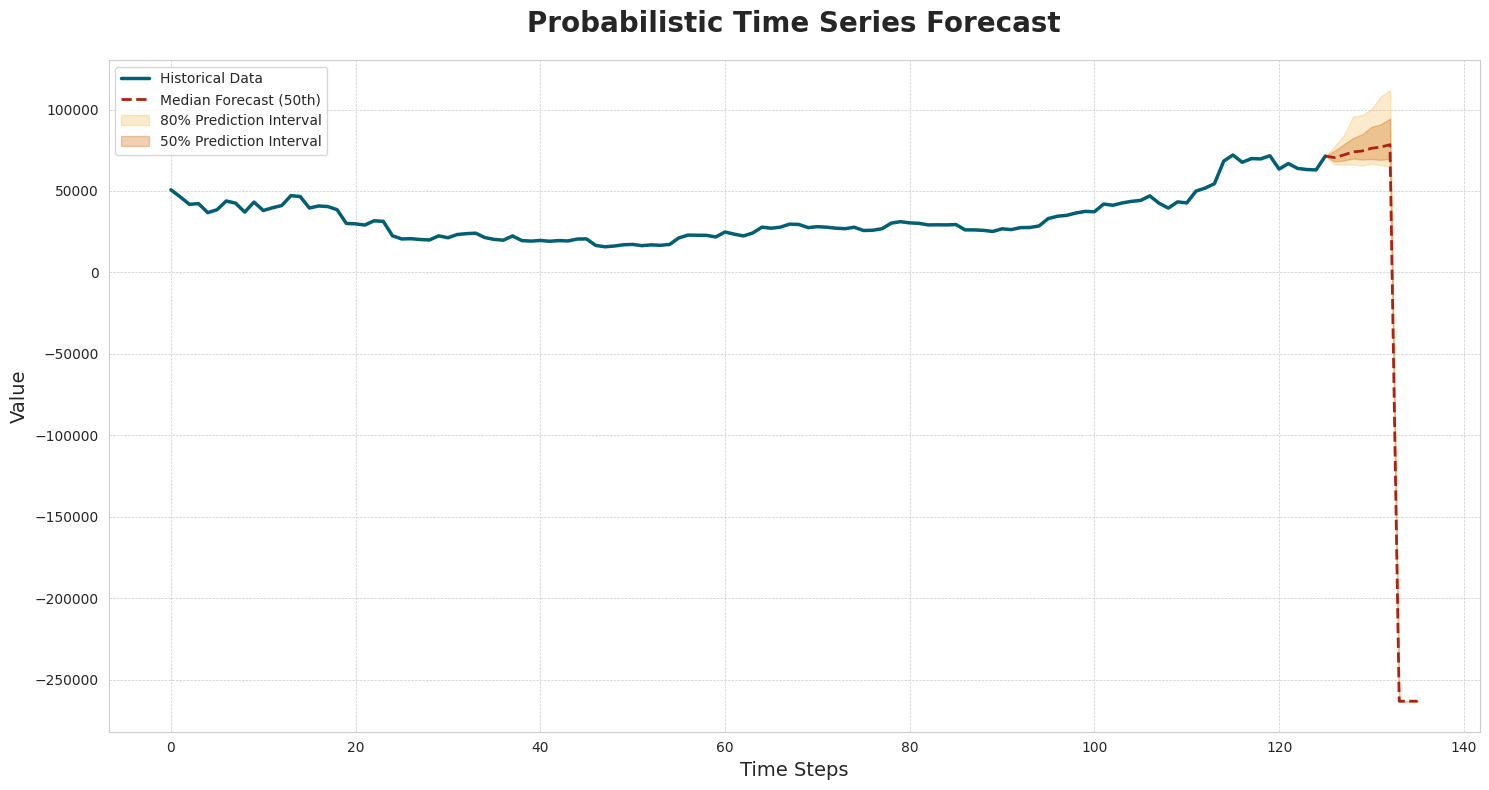

In [112]:
trajectories = normalized_trajectories

# --- 4. INVERSE TRANSFORM THE RESULTS ---
if trajectories is not None and trajectories.size > 0:
    # Step 4a: Apply the inverse sigmoid (logit) function to get back to standardized scale
    inverse_sigmoid_trajectories = inverse_sigmoid(trajectories)

    # Step 4b: Use the scaler to inverse transform back to the original data scale
    rescaled_trajectories = scaler.inverse_transform(inverse_sigmoid_trajectories)

    # --- 5. PLOT THE FINAL, RECONSTRUCTED RESULTS ---
    plot_forecast_cloud(historical_data, rescaled_trajectories)
else:
    print("Simulation did not produce valid trajectories.")

In [116]:
# historical_data = data['btc'].tolist()
# historical_data = np.array(historical_data[400:(len(historical_data)-horizon)])
actual_future_data = data['btc'].tolist()[-horizon]

TypeError: object of type 'float' has no len()

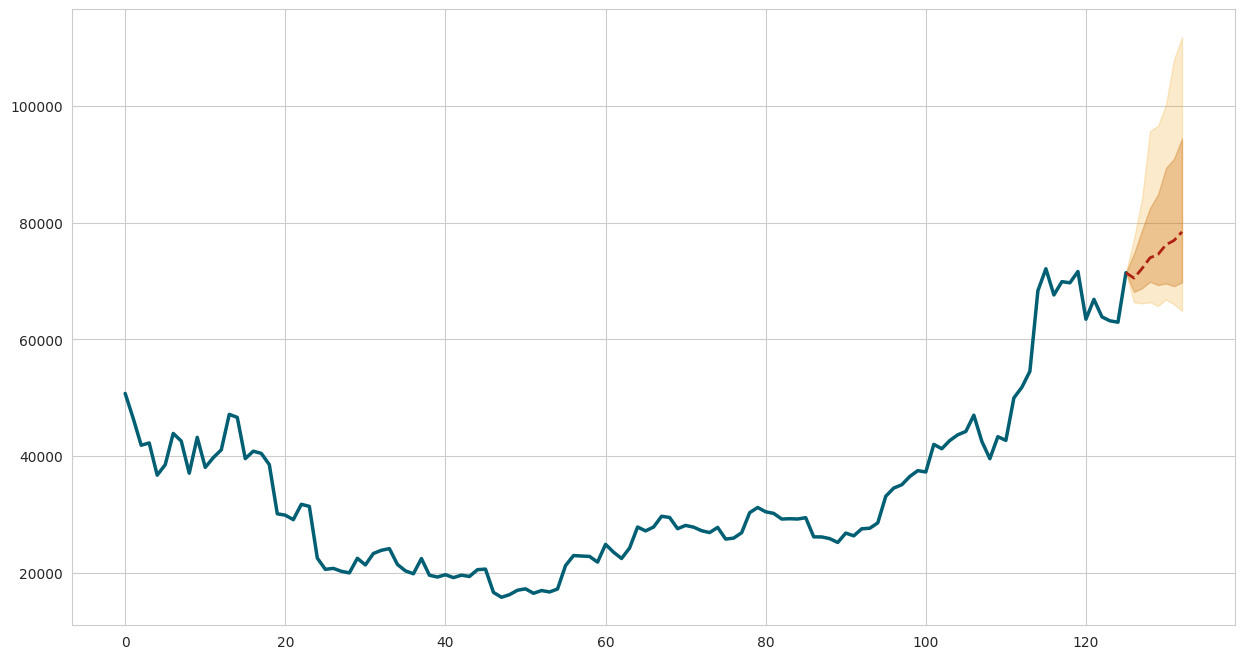

In [151]:
actual_future_data = data['btc'].tolist()

In [155]:
len(actual_future_data)-10
actual_future_data[-10:-3]

[86158.953, 78561.617, 84025.117, 87520.477, 82539.523, 79143.063, 84575.75]

In [153]:
historical_data

array([ 50714.73 ,  46450.789,  41832.59 ,  42224.379,  36702.789,
        38494.66 ,  43861.07 ,  42552.281,  37037.391,  43189.461,
        38030.629,  39696.281,  41043.898,  47128.711,  46609.359,
        39536.711,  40811.031,  40437.52 ,  38513.012,  30076.9  ,
        29838.5  ,  29075.68 ,  31703.6  ,  31353.779,  22471.59 ,
        20550.91 ,  20718.16 ,  20212.811,  19944.25 ,  22447.391,
        21305.59 ,  23271.57 ,  23817.721,  24101.689,  21399.66 ,
        20292.369,  19793.289,  22400.52 ,  19541.279,  19230.961,
        19632.35 ,  19131.359,  19550.49 ,  19331.061,  20492.561,
        20593.73 ,  16592.039,  15760.19 ,  16207.01 ,  16966.84 ,
        17208.66 ,  16442.789,  16916.07 ,  16670.08 ,  17179.029,
        21188.92 ,  22917.471,  22833.34 ,  22761.439,  21787.77 ,
        24838.09 ,  23490.07 ,  22410.34 ,  24205.82 ,  27807.289,
        27145.09 ,  27810.08 ,  29654.811,  29446.77 ,  27520.33 ,
        28086.189,  27781.   ,  27175.061,  26855.83 ,  27746.

In [ ]:
actual_future_data = np.array(actual_future_data[400:(len(actual_future_data)-horizon)])

In [125]:
data['btc'].tolist()[-11:]

[91536.969,
 86158.953,
 78561.617,
 84025.117,
 87520.477,
 82539.523,
 79143.063,
 84575.75,
 87515.57,
 95035.063,
 94767.953]

In [123]:
historical_data

array([50714.73 , 46450.789, 41832.59 , 42224.379, 36702.789, 38494.66 ,
       43861.07 , 42552.281, 37037.391, 43189.461, 38030.629, 39696.281,
       41043.898, 47128.711, 46609.359, 39536.711, 40811.031, 40437.52 ,
       38513.012, 30076.9  , 29838.5  , 29075.68 , 31703.6  , 31353.779,
       22471.59 , 20550.91 , 20718.16 , 20212.811, 19944.25 , 22447.391,
       21305.59 , 23271.57 , 23817.721, 24101.689, 21399.66 , 20292.369,
       19793.289, 22400.52 , 19541.279, 19230.961, 19632.35 , 19131.359,
       19550.49 , 19331.061, 20492.561, 20593.73 , 16592.039, 15760.19 ,
       16207.01 , 16966.84 , 17208.66 , 16442.789, 16916.07 , 16670.08 ,
       17179.029, 21188.92 , 22917.471, 22833.34 , 22761.439, 21787.77 ,
       24838.09 , 23490.07 , 22410.34 , 24205.82 , 27807.289, 27145.09 ,
       27810.08 , 29654.811, 29446.77 , 27520.33 , 28086.189, 27781.   ,
       27175.061, 26855.83 , 27746.07 , 25740.49 , 25905.801, 26837.26 ,
       30274.609, 31158.789, 30420.551, 30147.6  , 

In [75]:
k = normalized_trajectories>=1.
sum(k)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [23]:
from sklearn.preprocessing import MinMaxScaler

historical_data = data['btc'].tolist()
historical_data = np.array(historical_data[400:(len(historical_data)-horizon)])

# --- 1. NORMALIZATION STEP ---
# Reshape data for the scaler -> needs to be a 2D array
historical_data_reshaped = historical_data.reshape(-1, 1)

# Initialize and fit the scaler ONLY on historical data
scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(historical_data_reshaped)

# Transform the historical data into the 0-1 range
normalized_data = scaler.transform(historical_data_reshaped).flatten()

print(f"Original first value: {historical_data[0]:.2f}, Normalized: {normalized_data[0]:.4f}")
print(f"Original last value:  {historical_data[-1]:.2f}, Normalized: {normalized_data[-1]:.4f}")

Original first value: 50714.73, Normalized: 0.6205
Original last value:  71430.23, Normalized: 0.9882


In [120]:
historical_data = (data['btc']/100.).tolist()
historical_data = historical_data[400:(len(historical_data)-horizon)]

In [31]:
# 1. Run the simulation to get the future trajectories
trajectories = simulate_future_trajectories(
    prompt_text=prompt,
    generator_model=generator_q8_0,
    grammar_obj=grammar_obj,
    horizon=horizon,                    # How many steps into the future to predict
    num_simulations=num_simulations,    # Number of different futures to generate
    temperature=temperature             # Controls the "width" of the cloud
)


--- Running 10 simulations for a horizon of 50 steps ---


Simulating Trajectories:  20%|██        | 2/10 [00:06<00:26,  3.30s/it]


KeyboardInterrupt: 

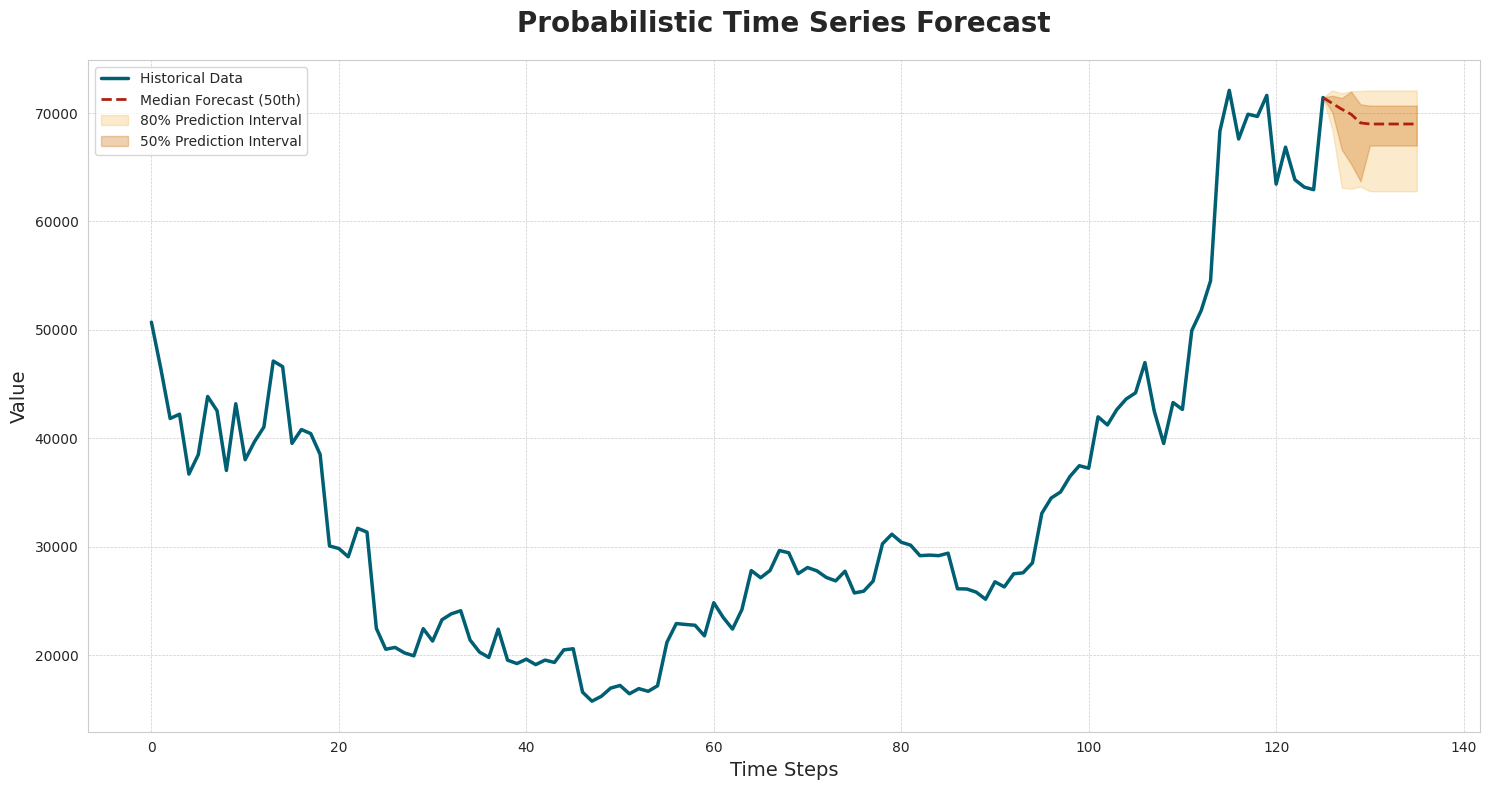

In [36]:
# --- 4. INVERSE TRANSFORM THE RESULTS ---
if normalized_trajectories is not None and normalized_trajectories.size > 0:
    # Rescale the forecast back to the original data's scale
    rescaled_trajectories = scaler.inverse_transform(normalized_trajectories)

    # --- 5. PLOT THE RESCALED RESULTS ---
    plot_forecast_cloud(historical_data, rescaled_trajectories)
else:
    print("Simulation did not produce valid trajectories.")

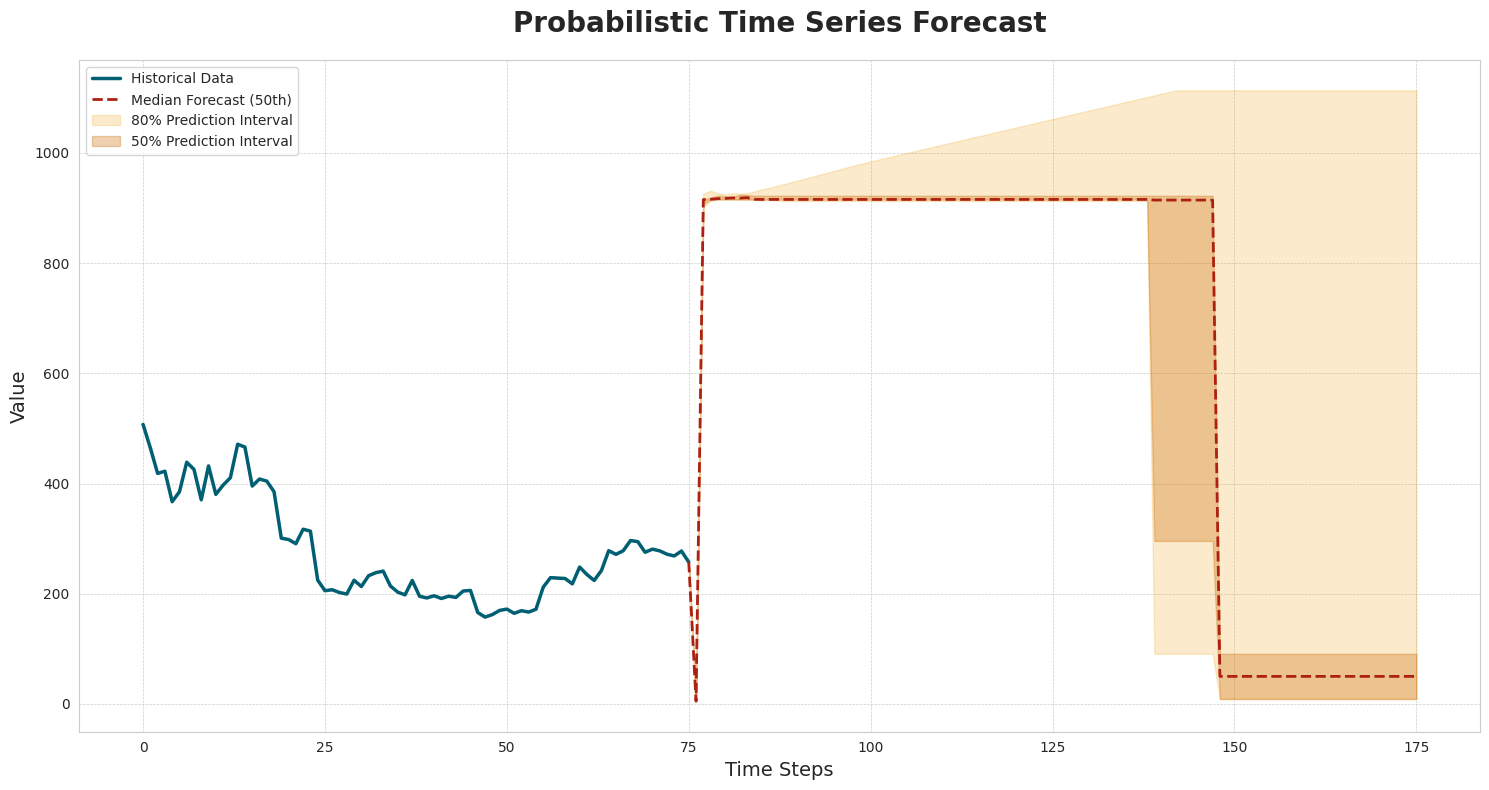

In [121]:
if trajectories is not None:
    plot_forecast_cloud(historical_data, trajectories)

In [112]:
trajectories

array([[5.0000000e+00, 9.1950420e+04, 9.0708390e+04, 9.1991380e+04,
        9.1754590e+04, 9.1352550e+04, 9.1600000e+02, 9.1600000e+02,
        9.1600000e+02, 9.1600000e+02],
       [5.0000000e+00, 9.1138130e+04, 9.1519100e+04, 9.1898520e+04,
        9.1453370e+04, 9.1259140e+04, 9.1400000e+02, 9.1400000e+02,
        9.1400000e+02, 9.1400000e+02],
       [5.0000000e+00, 9.1550400e+04, 9.1455360e+04, 9.1455360e+04,
        9.1455360e+04, 9.1455360e+04, 9.1400000e+02, 9.1400000e+02,
        9.1400000e+02, 9.1400000e+02],
       [5.0000000e+00, 9.3612740e+04, 9.4914300e+04, 9.5486170e+04,
        9.6215360e+04, 9.5953920e+04, 9.6600000e+02, 9.6600000e+02,
        9.6600000e+02, 9.6600000e+02],
       [5.0000000e+00, 9.1072160e+04, 9.0949120e+04, 9.0916820e+04,
        9.0894860e+04, 9.0894860e+04, 9.0800000e+02, 9.0800000e+02,
        9.0800000e+02, 9.0800000e+02],
       [5.0000000e+00, 9.1536975e+04, 9.1536975e+04, 9.1536975e+04,
        9.1536975e+04, 9.1536970e+04, 9.1536970e+04, 9.15

In [79]:
series_a = data['btc'].tolist()
print(series_a)

[441.92, 430.87, 438.21, 443.9, 582.01, 655.49, 644.35, 599.08, 591.17, 635.14, 613.6, 618.32, 625.13, 587.93, 592.77, 575.89, 462.18, 502.93, 477.19, 475.69, 477.71, 404.09, 376.77, 331.55, 387.32, 380.39, 350.09, 324.24, 367.15, 384.69, 378.85, 378.61, 364.95, 345.37, 330.84, 314.12, 274.84, 269.33, 215.87, 269.18, 238.86, 220.34, 235.83, 238.82, 273.75, 290.02, 290.41, 265.46, 246.79, 254.97, 223.59, 224.24, 228.96, 238.97, 241.81, 232.64, 237.41, 223.14, 228.57, 237.0, 247.46, 256.97, 269.08, 290.35, 277.68, 293.01, 281.58, 263.3, 257.13, 211.43, 229.47, 239.58, 229.91, 226.33, 238.87, 240.15, 245.35, 263.82, 285.15, 359.28, 380.22, 330.21, 322.12, 377.97, 394.28, 442.0, 437.59, 421.76, 433.32, 447.72, 384.4, 392.76, 372.18, 372.63, 401.07, 437.79, 436.21, 414.87, 414.31, 411.11, 422.21, 419.33, 421.43, 427.69, 461.73, 444.18, 460.44, 454.87, 443.69, 532.26, 583.58, 700.07, 733.97, 644.66, 675.16, 646.71, 670.38, 654.0, 607.0, 589.24, 566.95, 587.47, 574.23, 605.76, 607.98, 609.85,

In [86]:
def run_rolling_forecast_simulation(
    series_a,
    start_index,
    horizon,
    generator_model,
    grammar_obj,
    num_simulations=100,
    temperature=0.7
):
    if not grammar_obj or not generator_model:
        return None

    all_distributions = []
    print(f"\n--- Running efficient rolling forecast for a horizon of {horizon} steps ---")

    # Convert series_a and series_b into sequences of float strings with 4 decimal places
    sequence_a = ['%.2f' % x for x in series_a]

    # Construct the full context for this specific time step `t`
    # The context includes all history up to a[start_index], ready to predict b[start_index]
    context_list = sequence_a[:start_index]
    print(f"\ncontext_list length: {len(context_list)}")

    # 1. Initialize the context state ONCE before the loop
    generator_model.reset()

    prompt_text = ",".join(context_list) + ","
    initial_tokens = generator_model.tokenize(prompt_text.encode("utf-8"), add_bos=True)

    # --- CONTEXT WINDOW TRUNCATION FIX ---
    # Ensure the initial context does not exceed the model's context window (n_ctx).
    # We leave a buffer for future generated tokens.
    n_ctx = generator_model.n_ctx()
    max_initial_tokens = n_ctx - (horizon * 10) # Leave a generous buffer

    if len(initial_tokens) > max_initial_tokens:
        print(f"Warning: Initial context ({len(initial_tokens)} tokens) is too long. Truncating to the most recent {max_initial_tokens} tokens.")
        initial_tokens = initial_tokens[-max_initial_tokens:]
    # --- END OF FIX ---

    # 2. "Warm up" the model by evaluating the (potentially truncated) history in chunks
    print(f"Warming up model with {len(initial_tokens)} initial tokens...")
    n_batch = generator_model.n_batch
    for i in range(0, len(initial_tokens), n_batch):
        batch = initial_tokens[i:i + n_batch]
        generator_model.eval(batch)
    print("Model warmup complete.")

    # The main loop iterates through each future time step
    for t in tqdm(range(start_index, start_index + horizon), desc="Forecasting Steps"):
        if t >= len(sequence_a):
            break

        # 2. Save the current state (which includes all history up to a[t])
        state = generator_model.save_state()

        # 3. Run Monte Carlo simulations for the current step `t`
        step_simulations = []
        for _ in range(num_simulations):
            generator_model.load_state(state) # Restore state for a clean simulation

            response = generator_model(
                "", # Prompt is empty because context is in the state
                max_tokens=10,
                temperature=temperature,
                grammar=grammar_obj,
                stop=[","]
            )
            try:
                step_simulations.append(float(response['choices'][0]['text']))
            except (ValueError, IndexError):
                continue

        all_distributions.append(step_simulations)

        # 4. **Update the state with the ACTUAL known values for the next step**
        # This is the crucial efficiency gain. We only eval the two new tokens.
        if t + 1 < len(sequence_a):
            # The new information is the actual b[t] and the next a[t+1]
            update_text = sequence_a[t] + ","
            update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
            generator_model.eval(update_tokens) # This appends to the KV cache

    return all_distributions

In [93]:
distributions = run_rolling_forecast_simulation(
    series_a=series_a,
    start_index=start_index,
    horizon=horizon,
    generator_model=generator_model,
    grammar_obj=grammar_obj,
    num_simulations=num_simulations,
    temperature=temperature
)


--- Running efficient rolling forecast for a horizon of 5 steps ---

context_list length: 550
Warming up model with 1998 initial tokens...
Model warmup complete.


Forecasting Steps:   0%|          | 0/5 [05:09<?, ?it/s]


KeyboardInterrupt: 

In [82]:
# --- Plotting Function (Unchanged) ---
def plot_forecast_cloud(historical_data, forecast_distributions):
    if not forecast_distributions: return
    q10 = [np.quantile(dist, 0.10) if dist else np.nan for dist in forecast_distributions]
    q25 = [np.quantile(dist, 0.25) if dist else np.nan for dist in forecast_distributions]
    q50 = [np.quantile(dist, 0.50) if dist else np.nan for dist in forecast_distributions]
    q75 = [np.quantile(dist, 0.75) if dist else np.nan for dist in forecast_distributions]
    q90 = [np.quantile(dist, 0.90) if dist else np.nan for dist in forecast_distributions]
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1
    q10 = np.insert(q10, 0, last_hist_value); q25 = np.insert(q25, 0, last_hist_value); q50 = np.insert(q50, 0, last_hist_value); q75 = np.insert(q75, 0, last_hist_value); q90 = np.insert(q90, 0, last_hist_value)
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))
    sns.set_style("whitegrid"); plt.figure(figsize=(15, 8))
    historical_time = np.arange(len(historical_data))
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)
    plt.title('Efficient Rolling Conditional Forecast', fontsize=20, weight='bold', pad=20); plt.xlabel('Time Steps', fontsize=14); plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left'); plt.grid(True, which='both', linestyle='--', linewidth=0.5); plt.tight_layout(); plt.show()

In [83]:
historical_a = series_a[(start_index-100):start_index]

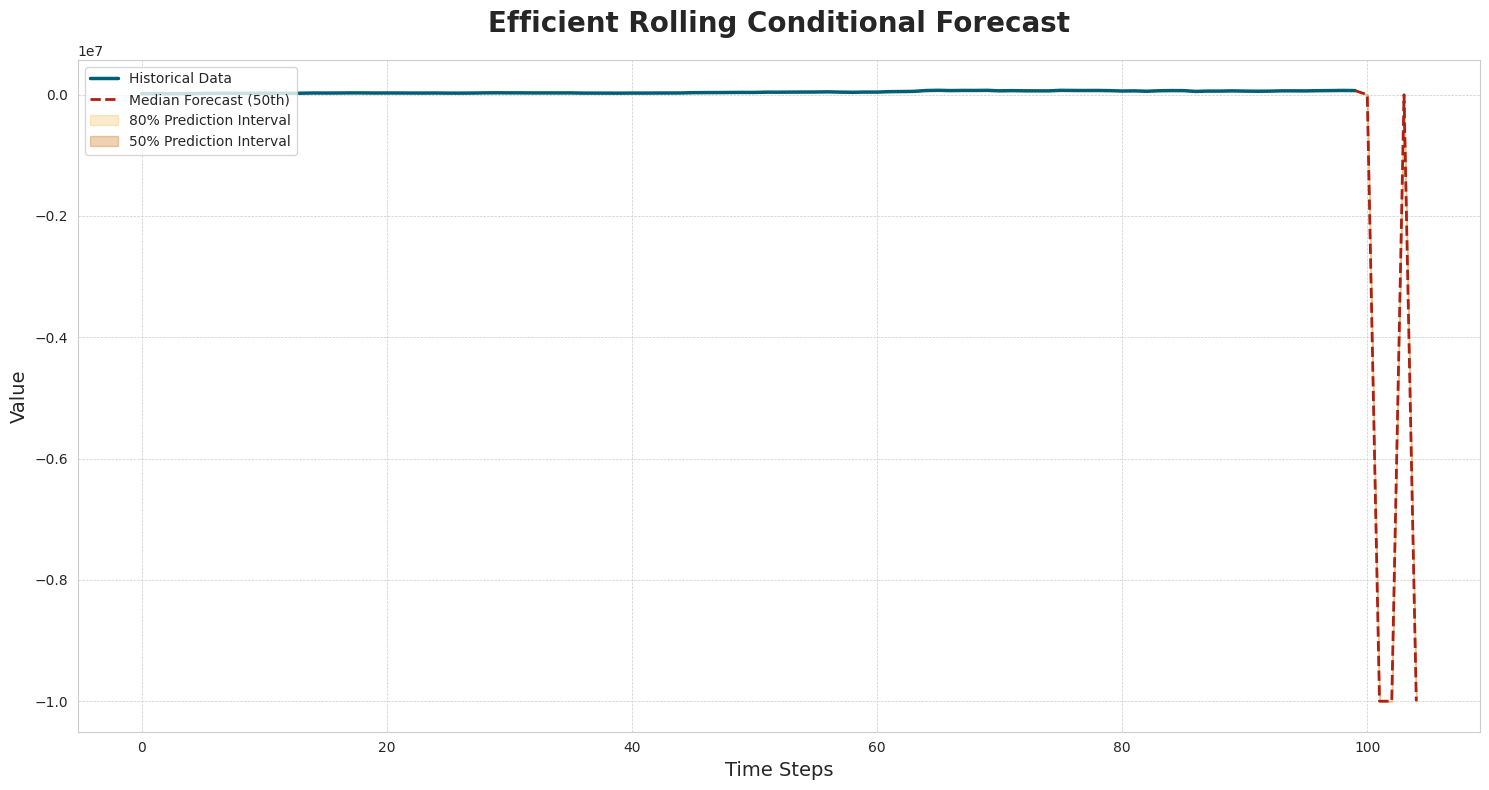

In [91]:
plot_forecast_cloud(historical_a, distributions)

In [36]:
def create_interleaved_lagged_sequence(series_a, series_b, lag=0):
    """Creates a lagged interleaved sequence using a list comprehension"""
    if lag<0:
        lag = 0
    sequence = [
        item
        for t in range(len(series_a))
        if t + lag < len(series_b)
        for item in (series_a[t], series_b[t + lag])
    ]
    return sequence

In [65]:
def run_rolling_forecast_simulation(
    series_a,
    series_b,
    start_index,
    horizon,
    generator_model,
    grammar_obj,
    num_simulations=100,
    temperature=0.7
):
    if not grammar_obj or not generator_model:
        return None

    all_distributions = []
    print(f"\n--- Running efficient rolling forecast for a horizon of {horizon} steps ---")

    # Convert series_a and series_b into sequences of float strings with 4 decimal places
    sequence_a = ['%.2f' % x for x in series_a]
    sequence_b = ['%.2f' % x for x in series_b]

    # Construct the full context for this specific time step `t`
    context_list = create_interleaved_lagged_sequence(sequence_a[:start_index], sequence_b[:start_index])
    # The context includes all history up to a[start_index], ready to predict b[start_index]
    context_list.append(sequence_a[start_index])
    print(f"\ncontext_list length: {len(context_list)}")

    # 1. Initialize the context state ONCE before the loop
    generator_model.reset()

    # # Create the initial interleaved history
    # initial_context_list = []
    # for i in range(start_index):
    #     initial_context_list.append(sequence_a_str[i])
    #     initial_context_list.append(sequence_b_str[i])

    # # The first prompt will be to predict b[start_index]
    # initial_context_list.append(sequence_a_str[start_index])

    # prompt_text = ",".join(context_list) + ","
    # prompt_tokens = generator_model.tokenize(prompt_text.encode("utf-8"), add_bos=True)

    # # This is the only "long" evaluation we do.
    # generator_model.eval(prompt_tokens)


    prompt_text = ",".join(context_list) + ","
    initial_tokens = generator_model.tokenize(prompt_text.encode("utf-8"), add_bos=True)

    # # 2. "Warm up" the model by evaluating the history in chunks
    # print(f"Warming up model with {len(initial_tokens)} initial tokens...")
    # print(f"\nInitial tokens: {initial_tokens}")
    # n_batch = generator_model.n_batch
    # print(f"\nn_batch: {n_batch}")
    # for i in range(0, len(initial_tokens), n_batch):
    #     batch = initial_tokens[i:i + n_batch]
    #     generator_model.eval(batch)
    # print("Model warmup complete.")


    # --- CONTEXT WINDOW TRUNCATION FIX ---
    # Ensure the initial context does not exceed the model's context window (n_ctx).
    # We leave a buffer for future generated tokens.
    n_ctx = generator_model.n_ctx()
    max_initial_tokens = n_ctx - (horizon * 10) # Leave a generous buffer

    if len(initial_tokens) > max_initial_tokens:
        print(f"Warning: Initial context ({len(initial_tokens)} tokens) is too long. Truncating to the most recent {max_initial_tokens} tokens.")
        initial_tokens = initial_tokens[-max_initial_tokens:]
    # --- END OF FIX ---

    # 2. "Warm up" the model by evaluating the (potentially truncated) history in chunks
    print(f"Warming up model with {len(initial_tokens)} initial tokens...")
    n_batch = generator_model.n_batch
    for i in range(0, len(initial_tokens), n_batch):
        batch = initial_tokens[i:i + n_batch]
        generator_model.eval(batch)
    print("Model warmup complete.")



    # The main loop iterates through each future time step
    for t in tqdm(range(start_index, start_index + horizon), desc="Forecasting Steps"):
        if t >= len(sequence_a) or t >= len(sequence_b):
            break

        # 2. Save the current state (which includes all history up to a[t])
        state = generator_model.save_state()

        # 3. Run Monte Carlo simulations for the current step `t`
        step_simulations = []
        for _ in range(num_simulations):
            generator_model.load_state(state) # Restore state for a clean simulation

            response = generator_model(
                "", # Prompt is empty because context is in the state
                max_tokens=10,
                temperature=temperature,
                grammar=grammar_obj,
                stop=[","]
            )
            try:
                step_simulations.append(float(response['choices'][0]['text']))
            except (ValueError, IndexError):
                continue

        all_distributions.append(step_simulations)

        # 4. **Update the state with the ACTUAL known values for the next step**
        # This is the crucial efficiency gain. We only eval the two new tokens.
        if t + 1 < len(sequence_a):
            # The new information is the actual b[t] and the next a[t+1]
            update_text = sequence_b[t] + "," + sequence_a[t+1] + ","
            update_tokens = generator_model.tokenize(update_text.encode("utf-8"), add_bos=False)
            generator_model.eval(update_tokens) # This appends to the KV cache

    return all_distributions

In [66]:
distributions = run_rolling_forecast_simulation(
    series_a=series_a,
    series_b=series_b,
    start_index=start_index,
    horizon=horizon,
    generator_model=generator_model,
    grammar_obj=grammar_obj,
    num_simulations=num_simulations,
    temperature=temperature
)


--- Running efficient rolling forecast for a horizon of 5 steps ---

context_list length: 1101
Warming up model with 1998 initial tokens...
Model warmup complete.


Forecasting Steps: 100%|██████████| 5/5 [00:11<00:00,  2.21s/it]


In [67]:
# --- Plotting Function (Unchanged) ---
def plot_forecast_cloud(historical_data, forecast_distributions):
    if not forecast_distributions: return
    q10 = [np.quantile(dist, 0.10) if dist else np.nan for dist in forecast_distributions]
    q25 = [np.quantile(dist, 0.25) if dist else np.nan for dist in forecast_distributions]
    q50 = [np.quantile(dist, 0.50) if dist else np.nan for dist in forecast_distributions]
    q75 = [np.quantile(dist, 0.75) if dist else np.nan for dist in forecast_distributions]
    q90 = [np.quantile(dist, 0.90) if dist else np.nan for dist in forecast_distributions]
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1
    q10 = np.insert(q10, 0, last_hist_value); q25 = np.insert(q25, 0, last_hist_value); q50 = np.insert(q50, 0, last_hist_value); q75 = np.insert(q75, 0, last_hist_value); q90 = np.insert(q90, 0, last_hist_value)
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))
    sns.set_style("whitegrid"); plt.figure(figsize=(15, 8))
    historical_time = np.arange(len(historical_data))
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)
    plt.title('Efficient Rolling Conditional Forecast', fontsize=20, weight='bold', pad=20); plt.xlabel('Time Steps', fontsize=14); plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left'); plt.grid(True, which='both', linestyle='--', linewidth=0.5); plt.tight_layout(); plt.show()

In [59]:
# --- EDITED Plotting Function ---
def plot_forecast_cloud(historical_data, forecast_distributions):
    if not forecast_distributions:
        print("No forecast data to plot.")
        return

    # --- NEW: Outlier Filtering Logic ---
    # This logic prevents extreme outlier predictions from ruining the plot's scale.
    hist_mean = np.mean(historical_data)
    hist_std = np.std(historical_data)
    # Define outlier bounds. We can use a generous multiple of the standard deviation.
    # Any prediction more than 15 standard deviations from the historical mean will be ignored.
    upper_bound = hist_mean + 15 * hist_std
    lower_bound = hist_mean - 15 * hist_std

    print(f"\nFiltering outliers outside of the reasonable range ({lower_bound:.2f}, {upper_bound:.2f})...")

    filtered_distributions = []
    for i, dist in enumerate(forecast_distributions):
        if not dist:
            filtered_distributions.append([])
            continue

        # Keep only the values within the sane bounds
        sane_dist = [x for x in dist if lower_bound <= x <= upper_bound]

        # If filtering removes all data, it indicates a problem at that step
        if not sane_dist:
             print(f"Warning: All simulated values at forecast step {i} were outliers and have been removed.")
             filtered_distributions.append([])
        else:
             filtered_distributions.append(sane_dist)
    # --- END OF NEW LOGIC ---

    # Calculate quantiles from the *filtered* distributions
    # This will now produce a stable plot.
    q10 = [np.quantile(dist, 0.10) if dist else np.nan for dist in filtered_distributions]
    q25 = [np.quantile(dist, 0.25) if dist else np.nan for dist in filtered_distributions]
    q50 = [np.quantile(dist, 0.50) if dist else np.nan for dist in filtered_distributions]
    q75 = [np.quantile(dist, 0.75) if dist else np.nan for dist in filtered_distributions]
    q90 = [np.quantile(dist, 0.90) if dist else np.nan for dist in filtered_distributions]

    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Anchor the forecast to the last historical point
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))

    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    historical_time = np.arange(len(historical_data))
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    plt.title('Efficient Rolling Conditional Forecast', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

In [70]:
historical_b = series_b[(start_index-100):start_index]

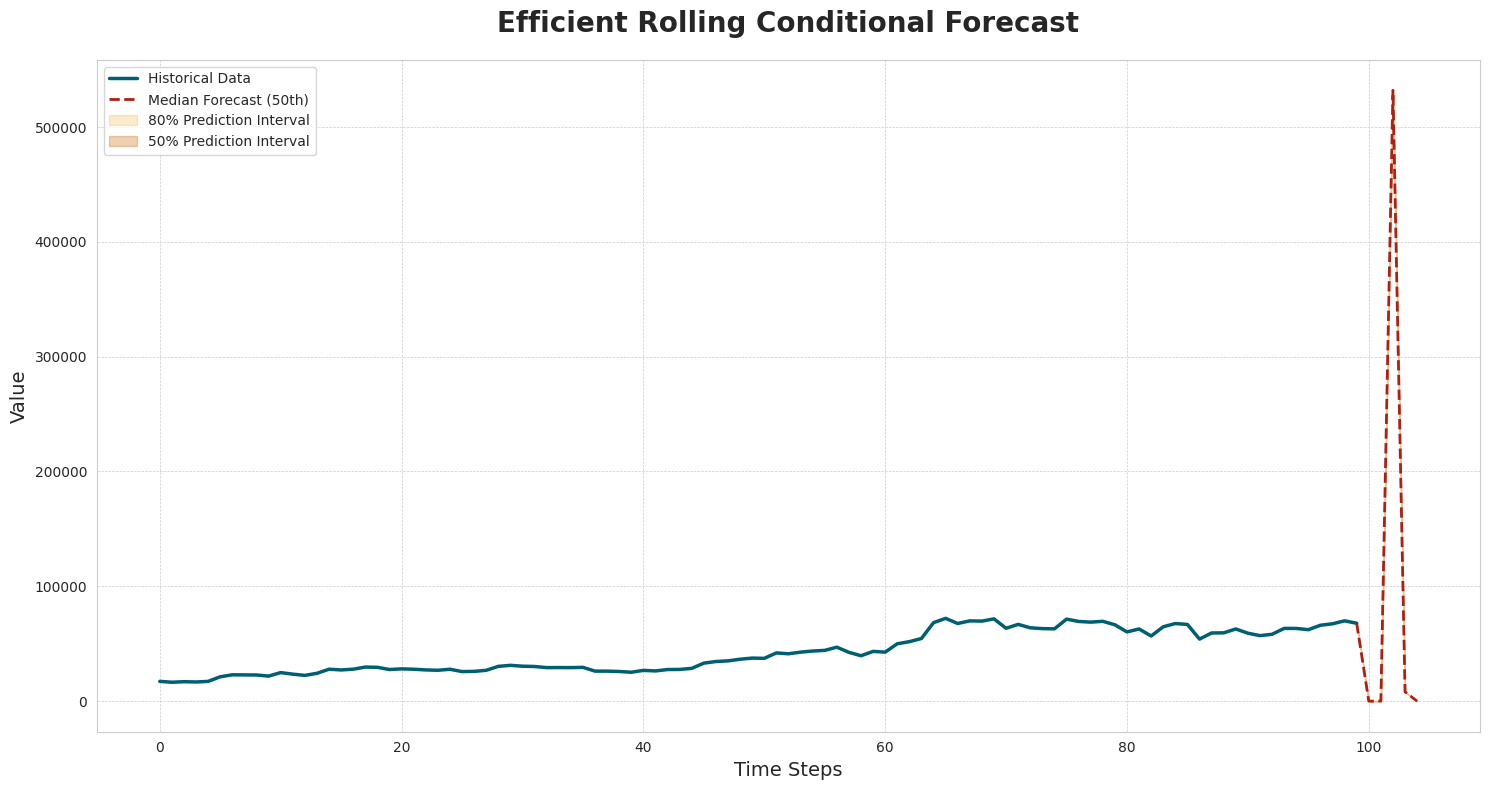

In [71]:
plot_forecast_cloud(historical_b, distributions)

In [41]:
def run_rolling_forecast_simulation(
    series_a,
    series_b,
    start_index,
    horizon,
    generator_model,
    grammar_obj,
    num_simulations=100,
    temperature=0.7
):
    """
    Efficiently runs a rolling conditional forecast simulation.
    """
    if not grammar_obj or not generator_model:
        return None

    all_distributions = []
    print(f"\n--- Running rolling forecast for a horizon of {horizon} steps ---")

    # Convert series_a and series_b into sequences of float strings with 4 decimal places
    sequence_a = ['%.4f' % x for x in series_a]
    sequence_b = ['%.4f' % x for x in series_b]

    # Construct the full context for this specific time step `t`
    context_list = create_interleaved_lagged_sequence(sequence_a[:start_index], sequence_b[:start_index])

    # The main loop iterates through each future time step we want to predict
    for t in tqdm(range(start_index, start_index + horizon), desc="Forecasting Steps"):
        if t >= len(sequence_a) or t >= len(sequence_b):
            print(f"Warning: Reached end of available data at step {t}. Stopping.")
            break


        # The context includes all history up to a[t], ready to predict b[t]
        context_list.append(sequence_a[t])

        prompt_text = ",".join(context_list) + ","

        # 2. Warm up the KV Cache and Save the State
        generator_model.reset()
        prompt_tokens = generator_model.tokenize(prompt_text.encode("utf-8"), add_bos=True)
        print(f"\nPrompt tokens: {prompt_tokens}")
        generator_model.eval(prompt_tokens)
        # This snapshot contains the state after processing the full history
        state = generator_model.save_state()

        # 3. Run the Monte Carlo simulations for this single step `t`
        step_simulations = []
        for _ in range(num_simulations):
            # Restore the warmed-up state - this is very fast
            generator_model.load_state(state)

            # Generate just the next number
            response = generator_model(
                "", # Prompt is empty because context is in the state
                max_tokens=10, # Enough for one number
                temperature=temperature,
                grammar=grammar_obj,
                stop=[","] # Stop after the number
            )

            generated_text = response['choices'][0]['text']
            try:
                num = float(generated_text)
                step_simulations.append(num)
            except ValueError:
                continue

        context_list.append(sequence_b[t])

        all_distributions.append(step_simulations)

    return all_distributions

# experiments (sapheneia_v1)

In [ ]:
# Define the grammar in GBNF format
# This grammar allows for a sequence of numbers (integers or decimals) separated by commas
# https://g.co/gemini/share/938d5c086f74
gbnf_grammar_str = r'''
root   ::= sequence
sequence ::= number ("," number)*
number ::= ("-")? ([0-9]+ | [0-9]+ "." [0-9]+)
'''
try:
    grammar = LlamaGrammar.from_string(gbnf_grammar_str)
    print("Strict grammar parsed successfully")
    print(grammar)
except Exception as e:
    print(f"Error parsing grammar: {e}")
    grammar = None

Strict grammar parsed successfully


## testing all quantized models

In [ ]:
# Define the prompt with number sequence
prompt = "1.0,2.1,3.3,4.2,5.7,"
#prompt = "1,2,3,4,5,"

In [ ]:
# Define parameters for running the model
# https://g.co/gemini/share/5e0aed5cf4b8
# https://g.co/gemini/share/8e15743e2cd6
# https://g.co/gemini/share/1dcee2a72019
parameters = {
    'max_tokens': 20, # Maximum number of output generated tokens
    'logprobs': 1000, # Number of output token-level log probabilities
    'grammar': grammar, # Valid grammar for output generation
    'temperature': 0.9 # Temperature calibrating the 'surprise of the output generation
}

In [ ]:
# Dictionary with all generators
generators = {
    'q2_k': generator_q2_k,
    'q4_k_m': generator_q4_k_m,
    'q6_k': generator_q6_k,
    'q8_0': generator_q8_0,
}

In [ ]:
# Generate output sequence and logprobs
def time_execution(generator, prompt, params):

    start_time = time.time()
    response = generator(prompt, **params)
    end_time = time.time()
    elapsed_time = end_time - start_time

    choice = response['choices'][0]
    text = choice['text']
    logprobs = choice['logprobs']

    return {'response': text,
            'logprobs': logprobs,
            'elapsed_time': elapsed_time}

In [ ]:
# Run results for all models in dict generators
results = {}
r = []
t = []

for key in generators:
    results[key] = {}
    print(f'### Running {key}')
    results[key] = time_execution(generators[key], prompt, parameters)
    s = results[key]['response']
    print(f'\tresponse = {s}')
    s = results[key]['logprobs']
    print(f'\tlogprobs = {s}')
    s = results[key]['elapsed_time']
    print(f'\telapsed_time = {s}')

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
results['q8_0']['logprobs']['top_logprobs'][0]

{'6': np.float32(-0.25368243),
 '7': np.float32(-2.4792635),
 '5': np.float32(-3.5000985),
 '1': np.float32(-4.193024),
 '8': np.float32(-4.2830863),
 '4': np.float32(-4.7845225),
 ' ': np.float32(-4.873134),
 '2': np.float32(-5.091663),
 '\n': np.float32(-5.1550307),
 '3': np.float32(-5.209435),
 '9': np.float32(-5.6851115),
 '0': np.float32(-5.975576),
 ' and': np.float32(-6.0301027),
 ' etc': np.float32(-6.917441),
 '<': np.float32(-6.980359),
 'and': np.float32(-7.1213536),
 ' or': np.float32(-7.17541),
 'etc': np.float32(-7.205487),
 '...': np.float32(-7.3786025),
 ' ...': np.float32(-7.724187),
 '  ': np.float32(-7.7778745),
 ' .': np.float32(-7.806314),
 'max': np.float32(-7.841784),
 ' (': np.float32(-7.89041),
 'y': np.float32(-7.902519),
 ' A': np.float32(-8.017706),
 ' <': np.float32(-8.086822),
 'n': np.float32(-8.155408),
 'A': np.float32(-8.206924),
 'x': np.float32(-8.24764),
 'N': np.float32(-8.25274),
 'a': np.float32(-8.272391),
 ' -': np.float32(-8.278733),
 '*': np.

In [ ]:
results['q8_0']['response']

'7.2,8.7,10.2,12.2,14'

### save single token log-probabilities

In [ ]:
logprobs = results['q8_0']['logprobs']['top_logprobs'][0].copy()

In [ ]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json'

In [ ]:
for key in logprobs:
    logprobs[key] = float(logprobs[key])

with open(file_path, 'w') as json_file:
    json.dump(logprobs, json_file, indent=4)

### save token sequence

In [ ]:
response = {}

for key in generators:
    response[key] = results[key]['response']

response

{'q2_k': '10.1,20.2,30.4,40.8,',
 'q4_k_m': '6.8,7.9,8.8,9.8,10.8',
 'q6_k': '7.2,8.8,10.5,12.1,14',
 'q8_0': '7.2,8.7,10.2,12.2,14'}

In [ ]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json'

In [ ]:
with open(file_path, 'w') as json_file:
    json.dump(response, json_file, indent=4)

## analysis of single token log-probabilities

In [ ]:
# Load sample logprobs for analysis
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json'

logprobs = {}

try:
    with open(file_path, 'r') as json_file:
        logprobs = json.load(json_file)
    print(f"Dictionary loaded from {file_path}:")
    print(logprobs)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}.")

Dictionary loaded from /content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/generator_q8_0_logprobs.json:
{'6': -0.272904634475708, '7': -2.412665605545044, '5': -3.4727232456207275, '1': -4.10285758972168, '8': -4.194048881530762, '4': -4.7399492263793945, ' ': -4.851360321044922, '2': -5.01570987701416, '\n': -5.0478715896606445, '3': -5.1466779708862305, '9': -5.572190284729004, ' and': -5.918932914733887, '0': -5.939314842224121, ' etc': -6.749886512756348, '<': -7.024115562438965, 'and': -7.046576499938965, ' or': -7.070944786071777, 'etc': -7.102926254272461, '...': -7.291332244873047, ' ...': -7.644391059875488, '  ': -7.7795610427856445, 'max': -7.819403648376465, ' (': -7.824001312255859, ' .': -7.824521064758301, 'y': -7.828177452087402, ' A': -7.911307334899902, 'n': -8.026654243469238, ' <': -8.069267272949219, 'A': -8.102025032043457, 'a': -8.105005264282227, 'N': -8.14380931854248, ' -': -8.24870777130127, 'x': -8.262267112731934, '*': -8.35293865203857

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
logprobs

{'6': -0.272904634475708,
 '7': -2.412665605545044,
 '5': -3.4727232456207275,
 '1': -4.10285758972168,
 '8': -4.194048881530762,
 '4': -4.7399492263793945,
 ' ': -4.851360321044922,
 '2': -5.01570987701416,
 '\n': -5.0478715896606445,
 '3': -5.1466779708862305,
 '9': -5.572190284729004,
 ' and': -5.918932914733887,
 '0': -5.939314842224121,
 ' etc': -6.749886512756348,
 '<': -7.024115562438965,
 'and': -7.046576499938965,
 ' or': -7.070944786071777,
 'etc': -7.102926254272461,
 '...': -7.291332244873047,
 ' ...': -7.644391059875488,
 '  ': -7.7795610427856445,
 'max': -7.819403648376465,
 ' (': -7.824001312255859,
 ' .': -7.824521064758301,
 'y': -7.828177452087402,
 ' A': -7.911307334899902,
 'n': -8.026654243469238,
 ' <': -8.069267272949219,
 'A': -8.102025032043457,
 'a': -8.105005264282227,
 'N': -8.14380931854248,
 ' -': -8.24870777130127,
 'x': -8.262267112731934,
 '*': -8.352938652038574,
 ' &': -8.429669380187988,
 'or': -8.471209526062012,
 'min': -8.573104858398438,
 'in': 

In [ ]:
tokens = [',','.','-','0','1','2','3','4','5','6','7','8','9']

In [ ]:
distribution = pd.DataFrame(logprobs, index=['logprob']).T.reset_index()
distribution.columns = ['token','logprob']
k = distribution['token'].isin(tokens)
distribution = distribution[k].reset_index(drop=True)
distribution['prob'] = np.exp(distribution['logprob'])
distribution['prob'] = distribution['prob']/distribution['prob'].sum()

In [ ]:
distribution

,token,logprob,prob
0,6,-0.272905,0.808812
1,7,-2.412666,0.095183
2,5,-3.472723,0.032975
3,1,-4.102858,0.017560
4,8,-4.194049,0.016029
5,4,-4.739949,0.009286
6,2,-5.015710,0.007048
7,3,-5.146678,0.006183
8,9,-5.572190,0.004040
9,0,-5.939315,0.002799


## get float from token sequence

In [ ]:
import json

file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json'

token_sequences = {}

try:
    with open(file_path, 'r') as json_file:
        token_sequences = json.load(json_file)
    print(f"Dictionary loaded from {file_path}:")
    print(token_sequences)
except FileNotFoundError:
    print(f"Error: The file {file_path} was not found.")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {file_path}.")

Dictionary loaded from /content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/response_sequences.json:
{'q2_k': '10.1,20.2,30.4,40.8,', 'q4_k_m': '6.8,7.9,8.8,9.8,10.8', 'q6_k': '7.2,8.8,10.5,12.1,14', 'q8_0': '7.2,8.7,10.2,12.2,14'}


In [ ]:
def get_float_from_token_sequence(token_sequences):
    float_sequences = {}

    for key in token_sequences:
        float_sequences[key] = [float(x) for x in token_sequences[key].strip(',').split(',')]

    return float_sequences

In [ ]:
float_sequences = get_float_from_token_sequence(token_sequences)
float_sequences

{'q2_k': [10.1, 20.2, 30.4, 40.8],
 'q4_k_m': [6.8, 7.9, 8.8, 9.8, 10.8],
 'q6_k': [7.2, 8.8, 10.5, 12.1, 14.0],
 'q8_0': [7.2, 8.7, 10.2, 12.2, 14.0]}

## simulation

https://g.co/gemini/share/1c98cd1b5e97

In [ ]:
prompt = "1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0,"

In [ ]:
def run_monte_carlo_simulation(prompt, generator, grammar, num_simulations=100, temperature=0.7, max_tokens=10, print_step=50):
    """
    Runs N simulations to generate a distribution of the next predicted number.
    """
    if not grammar or not generator:
        print("Model or grammar not available.")
        return None

    print(f"\n--- Running {num_simulations} simulations with temperature={temperature} ---")

    generated_numbers = []

    for i in range(num_simulations):
        # Print progress every print_step simulations
        if (i + 1) % print_step == 0:
            print(f"  Running simulation {i + 1}/{num_simulations} ...")

        response = generator(
            prompt,
            max_tokens=max_tokens,
            temperature=temperature,
            grammar=grammar,
            stop=["\n", ","] # Stop after the first number is generated
        )

        generated_text = response['choices'][0]['text']

        # Use regex to find the first valid float/integer in the output
        match = re.search(r'-?\d+(\.\d+)?', generated_text)
        if match:
            try:
                # Convert the found number string to a float and add to our list
                num = float(match.group(0))
                generated_numbers.append(num)
            except ValueError:
                continue # Ignore if conversion fails for any reason

    return generated_numbers

In [ ]:
simulation_results = run_monte_carlo_simulation(
    prompt=prompt,
    generator=generator_q8_0,
    grammar=grammar,
    num_simulations=2000,
    temperature=0.9
)


--- Running 2000 simulations with temperature=0.9 ---
  Running simulation 50/2000...
  Running simulation 100/2000...
  Running simulation 150/2000...
  Running simulation 200/2000...
  Running simulation 250/2000...
  Running simulation 300/2000...
  Running simulation 350/2000...
  Running simulation 400/2000...
  Running simulation 450/2000...
  Running simulation 500/2000...
  Running simulation 550/2000...
  Running simulation 600/2000...
  Running simulation 650/2000...
  Running simulation 700/2000...
  Running simulation 750/2000...
  Running simulation 800/2000...
  Running simulation 850/2000...
  Running simulation 900/2000...
  Running simulation 950/2000...
  Running simulation 1000/2000...
  Running simulation 1050/2000...
  Running simulation 1100/2000...
  Running simulation 1150/2000...
  Running simulation 1200/2000...
  Running simulation 1250/2000...
  Running simulation 1300/2000...
  Running simulation 1350/2000...
  Running simulation 1400/2000...
  Running sim

In [ ]:
if simulation_results:
    # --- Analyze and Display the Distribution ---
    print("\n--- Simulation Results ---")

    # Count the occurrences of each unique number
    number_counts = Counter(simulation_results)

    total_samples = len(simulation_results)

    print(f"Generated {total_samples} valid numbers.")
    print("Top 10 most likely next numbers and their estimated probabilities:")

    # Sort by frequency and display the top 10
    for number, count in number_counts.most_common(10):
        probability = (count / total_samples) * 100
        print(f"  - Number: {number:<10} | Count: {count:<5} | Probability: {probability:.2f}%")


--- Simulation Results ---
Generated 2000 valid numbers.
Top 10 most likely next numbers and their estimated probabilities:
  - Number: 6.5        | Count: 209   | Probability: 10.45%
  - Number: 6.8        | Count: 127   | Probability: 6.35%
  - Number: 6.0        | Count: 120   | Probability: 6.00%
  - Number: 6.3        | Count: 105   | Probability: 5.25%
  - Number: 6.6        | Count: 103   | Probability: 5.15%
  - Number: 7.0        | Count: 99    | Probability: 4.95%
  - Number: 6.7        | Count: 95    | Probability: 4.75%
  - Number: 6.9        | Count: 91    | Probability: 4.55%
  - Number: 7.5        | Count: 89    | Probability: 4.45%
  - Number: 6.2        | Count: 81    | Probability: 4.05%


In [ ]:
# Calculate Statistics using NumPy ---
stats = {
    'mean': np.mean(simulation_results),
    'q10': np.quantile(simulation_results, 0.10),
    'q25': np.quantile(simulation_results, 0.25),
    'q50': np.quantile(simulation_results, 0.50), # Median
    'q75': np.quantile(simulation_results, 0.75),
    'q90': np.quantile(simulation_results, 0.90),
}

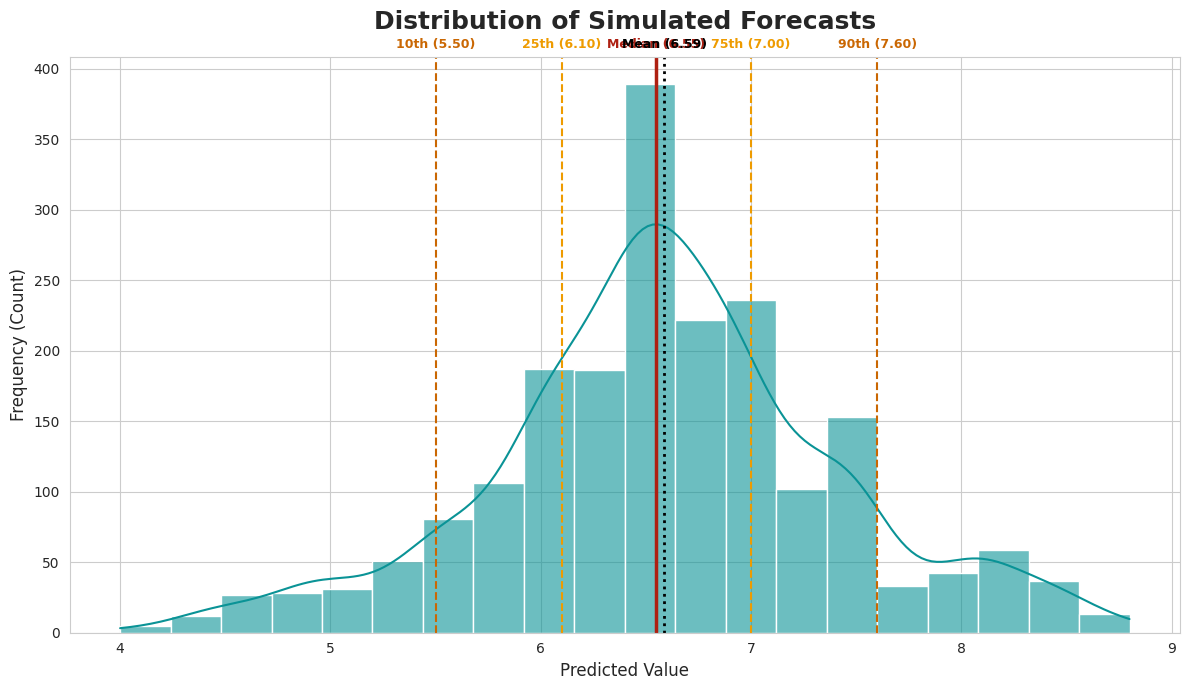


--- Calculated Statistics ---
Mean           : 6.588
Q10            : 5.500
Q25            : 6.100
Q50            : 6.550
Q75            : 7.000
Q90            : 7.600


In [ ]:
# Create the Plot ---
# Set a nice style for the plot
sns.set_style("whitegrid")
plt.figure(figsize=(12, 7))

# Create the histogram using seaborn for better aesthetics
# `kde=True` adds a smooth line representing the kernel density estimate
ax = sns.histplot(simulation_results, bins=20, kde=True, color='#0a9396', alpha=0.6)

# Add Vertical Lines and Labels for Stats ---
# Define the lines to draw
lines_to_draw = [
    {'value': stats['q10'], 'label': f"10th ({stats['q10']:.2f})", 'color': '#ca6702', 'style': '--'},
    {'value': stats['q25'], 'label': f"25th ({stats['q25']:.2f})", 'color': '#ee9b00', 'style': '--'},
    {'value': stats['q50'], 'label': f"Median ({stats['q50']:.2f})", 'color': '#ae2012', 'style': '-', 'width': 2.5},
    {'value': stats['mean'], 'label': f"Mean ({stats['mean']:.2f})", 'color': '#000000', 'style': ':', 'width': 2},
    {'value': stats['q75'], 'label': f"75th ({stats['q75']:.2f})", 'color': '#ee9b00', 'style': '--'},
    {'value': stats['q90'], 'label': f"90th ({stats['q90']:.2f})", 'color': '#ca6702', 'style': '--'}
]

# Plot each line
for line in lines_to_draw:
    plt.axvline(
        x=line['value'],
        color=line['color'],
        linestyle=line['style'],
        linewidth=line.get('width', 1.5),
        label=line['label']
    )
    # Add text label slightly above the plot
    plt.text(line['value'], ax.get_ylim()[1] * 1.01, line['label'], color=line['color'], ha='center', va='bottom', fontsize=9, weight='bold')


# --- Final Touches (Labels, Title) ---
plt.title('Distribution of Simulated Forecasts', fontsize=18, weight='bold', pad=20)
plt.xlabel('Predicted Value', fontsize=12)
plt.ylabel('Frequency (Count)', fontsize=12)
plt.legend().set_visible(False) # Hide the default legend as we have text labels
plt.tight_layout()
plt.show()

# --- Print the stats for reference ---
print("\n--- Calculated Statistics ---")
for key, value in stats.items():
    print(f"{key.capitalize():<15}: {value:.3f}")

In [ ]:
# Historical data that will be used in the prompt
historical_data = [1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0]
prompt = ",".join(map(str, historical_data)) + ","
prompt

'1.0,2.1,3.3,4.2,5.7,5.0,6.1,5.5,7.0,'

In [ ]:
def simulate_future_trajectories(
    prompt_text,
    generator_model,
    grammar_obj,
    horizon=20,
    num_simulations=100,
    temperature=0.7
):
    """
    Runs N simulations to generate multiple full future trajectories.
    """
    if not grammar_obj or not generator_model:
        return None

    all_trajectories = []
    print(f"\n--- Running {num_simulations} simulations for a horizon of {horizon} steps ---")

    # Use tqdm for a progress bar
    for _ in tqdm(range(num_simulations), desc="Simulating Trajectories"):
        response = generator_model(
            prompt_text,
            max_tokens=horizon * 5, # Generate enough tokens to get `horizon` numbers
            temperature=temperature,
            grammar=grammar_obj,
            stop=["\n"]
        )

        generated_text = response['choices'][0]['text']

        # Find all numbers in the generated string
        numbers_str = re.findall(r'-?\d+\.\d+|-?\d+', generated_text)

        # Convert to float and take only up to the desired horizon
        trajectory = [float(n) for n in numbers_str[:horizon]]

        # Ensure the trajectory has the correct length by padding if necessary
        while len(trajectory) < horizon:
            trajectory.append(trajectory[-1]) # Simple padding with the last value

        all_trajectories.append(trajectory)

    return np.array(all_trajectories)


In [ ]:
# 1. Run the simulation to get the future trajectories
trajectories = simulate_future_trajectories(
    prompt_text=prompt,
    generator_model=generator_q8_0,
    grammar_obj=grammar,
    horizon=10,          # How many steps into the future to predict
    num_simulations=1000, # Number of different futures to generate
    temperature=0.9      # Controls the "width" of the cloud
)


--- Running 1000 simulations for a horizon of 10 steps ---


Simulating Trajectories: 100%|██████████| 1000/1000 [09:43<00:00,  1.71it/s]


In [ ]:
def plot_forecast_cloud(historical_data, forecast_trajectories):
    """
    Visualizes historical data and a cloud of forecasted trajectories,
    ensuring the forecast is connected to the historical data.
    """
    # --- Calculate Quantiles ---
    q10 = np.quantile(forecast_trajectories, 0.10, axis=0)
    q25 = np.quantile(forecast_trajectories, 0.25, axis=0)
    q50 = np.quantile(forecast_trajectories, 0.50, axis=0)
    q75 = np.quantile(forecast_trajectories, 0.75, axis=0)
    q90 = np.quantile(forecast_trajectories, 0.90, axis=0)

    # --- THE CRITICAL FIX IS HERE ---
    # Get the last point of the historical data to anchor the forecast
    last_hist_value = historical_data[-1]
    last_hist_time = len(historical_data) - 1

    # Prepend the last historical value to each forecast quantile series
    q10 = np.insert(q10, 0, last_hist_value)
    q25 = np.insert(q25, 0, last_hist_value)
    q50 = np.insert(q50, 0, last_hist_value)
    q75 = np.insert(q75, 0, last_hist_value)
    q90 = np.insert(q90, 0, last_hist_value)

    # Adjust the forecast time axis to start from the last historical point
    forecast_time = np.arange(last_hist_time, last_hist_time + len(q50))
    # --- END OF FIX ---

    # --- Create the Plot ---
    sns.set_style("whitegrid")
    plt.figure(figsize=(15, 8))

    # Define the historical time axis
    historical_time = np.arange(len(historical_data))

    # Plot historical data
    plt.plot(historical_time, historical_data, color='#005f73', label='Historical Data', linewidth=2.5, zorder=3)

    # Plot the median forecast (50th percentile)
    plt.plot(forecast_time, q50, color='#ae2012', linestyle='--', label='Median Forecast (50th)', linewidth=2, zorder=3)

    # Create the "Cloud" using fill_between
    plt.fill_between(forecast_time, q10, q90, color='#ee9b00', alpha=0.2, label='80% Prediction Interval', zorder=1)
    plt.fill_between(forecast_time, q25, q75, color='#ca6702', alpha=0.3, label='50% Prediction Interval', zorder=2)

    # --- Final Touches ---
    plt.title('Probabilistic Time Series Forecast', fontsize=20, weight='bold', pad=20)
    plt.xlabel('Time Steps', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='upper left')
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.tight_layout()
    plt.show()

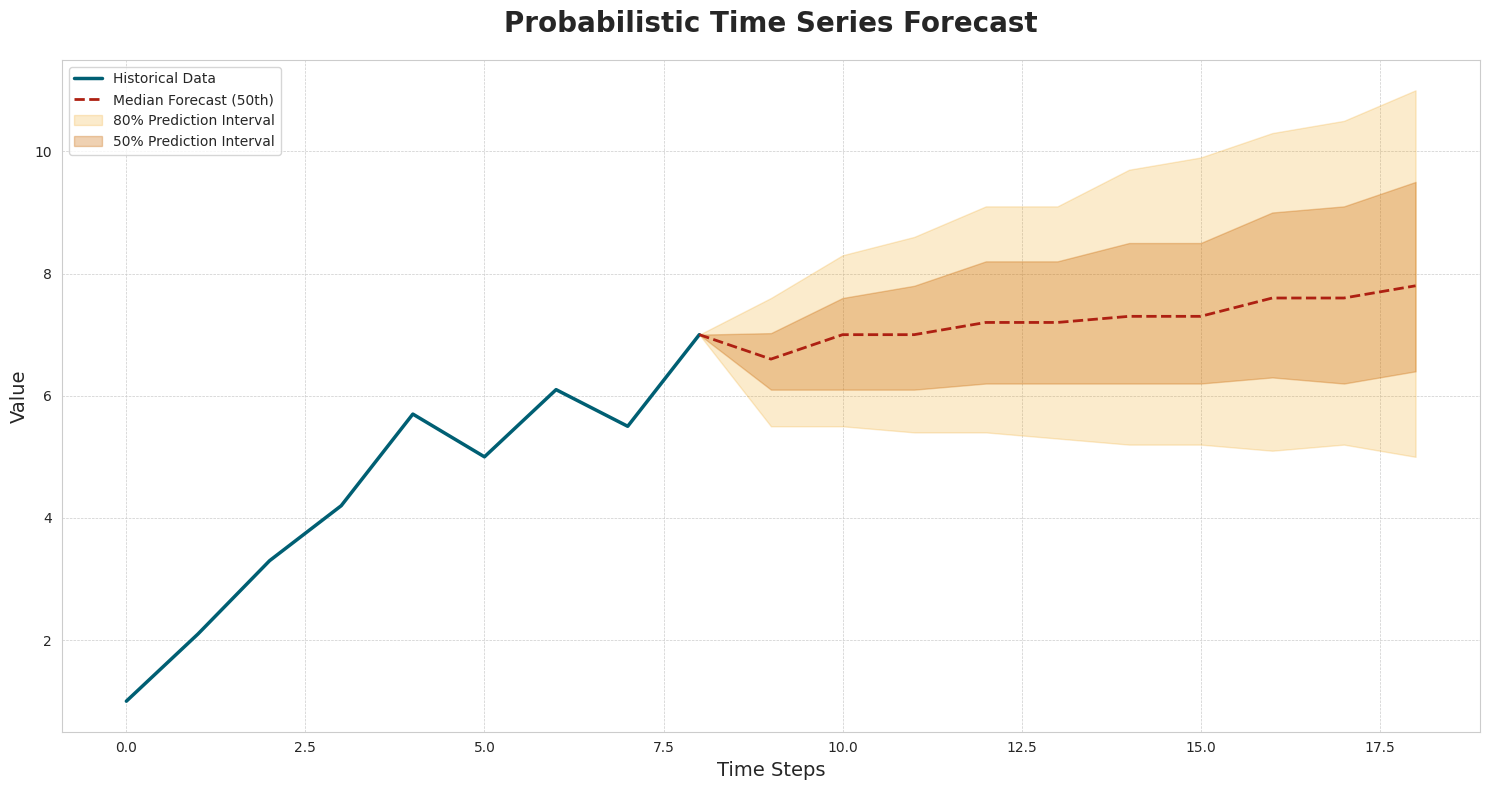

In [ ]:
if trajectories is not None:
    plot_forecast_cloud(historical_data, trajectories)

In [ ]:
trajectories[100]

array([5.9, 4.1, 5.5, 5.1, 5.1, 4.2, 4.2, 4.9, 4.7, 4. ])

In [ ]:
file_path = '/content/drive/MyDrive/dev/sapheneia/github/sapheneia/notebooks/marcelo/trajectories_simulation.npy'
np.save(file_path,trajectories)

In [ ]:
simulated_trajectories = np.load(file_path)
print(simulated_trajectories)

[[6.6 5.8 5.9 ... 3.9 3.9 3.7]
 [7.5 5.  6.2 ... 7.5 8.  5.2]
 [7.  6.1 6.7 ... 6.9 7.5 7.3]
 ...
 [6.5 7.4 6.8 ... 8.5 9.1 8.9]
 [7.2 7.1 7.4 ... 8.3 8.4 7.8]
 [7.  6.1 6.4 ... 4.2 5.  4.5]]


# time-series sequences with TinyLlama quantized models (sapheneia_v1)

### Introduction

- This action has been completed with the Notebook: https://github.com/labrem/sapheneia/blob/main/notebooks/marcelo/sapheneia_v1.ipynb.
- The following Gemini thread has been used to help build this up both conceptually and in practice: https://g.co/gemini/share/c5212fd78fad.
- This Notebook tests the capabilities of TinyLlama quantized models to generate raw token sequences given an input sequence.
- In order to speed up the model loading, the models have been stored in a local drive.

### Accomplishments

- With this Notebook we are able to achieve the following items.
    - Load and run a local drive instance of the TinyLlama model with different quantization levels (2-bit, 4-bit, 6-bit and 8-bit) on CPU as well as with GPU acceleration.
    - Compute the execution time for each model.
    - Check model behavior with different parameters such as:
    
    ```python
        parameters = {
        'max_tokens': 20, # Maximum number of output generated tokens
        'logprobs': 10, # Number of output token-level log probabilities
        'grammar': grammar, # Valid grammar for output generation
        'temperature': 0.9 # Temperature calibrating the 'surprise of the output generation
    }
    ```
    
    - Define a grammar such that it forces the model to output only certain to tokens such as numbers, period and comma.
    
    ```python
    gbnf_grammar_str = r'''
    root   ::= sequence
    sequence ::= number ("," number)*
    number ::= ("-")? ([0-9]+ | [0-9]+ "." [0-9]+)
    '''
    try:
        grammar = LlamaGrammar.from_string(gbnf_grammar_str)
        print("Strict grammar parsed successfully")
        print(grammar)
    except Exception as e:
        print(f"Error parsing grammar: {e}")
        grammar = None
    ```
    
    - Understand how to output generated token log probabilities. Note how in the log-probabilities for last number in the generated sequence below, where `1`, `2` and `.` appear as the highest probabilities to be sampled by the model. Also note how characters such as `\n` and `:` also show up in the top 10 probabilities, but is never selected in the generative process because it is not compliant with the established grammar.
    
    ```python
    prompt = "1.0,2.1,3.3,4.2,5.7,"
    ...
    ### Running q8_0
    	response = 6.7,7.6,8.9,10.4,12.
    ...
    ... {'1': np.float32(-0.110834435),
    '9': np.float32(-3.750521),
    '2': np.float32(-4.000365),
    '8': np.float32(-4.487987),
    '7': np.float32(-5.1254697),
    '0': np.float32(-5.1982684),
    '\n': np.float32(-5.263313),
    '6': np.float32(-5.366506),
    ' ': np.float32(-5.544479),
    '5': np.float32(-5.6029096)},
    {'2': np.float32(-0.5808073),
    '1': np.float32(-1.1937376),
    '3': np.float32(-2.658832),
    '0': np.float32(-3.187264),
    '4': np.float32(-4.535298),
    '5': np.float32(-5.0283246),
    '.': np.float32(-5.481704),
    '6': np.float32(-6.451225),
    '7': np.float32(-6.923182),
    '8': np.float32(-7.3887563)},
    {'.': np.float32(-0.03789382),
    ',': np.float32(-3.8787103),
    '\n': np.float32(-5.5151057),
    ' ': np.float32(-6.6268954),
    ':': np.float32(-7.178901),
    ')': np.float32(-7.3973727),
    '.,': np.float32(-7.824158),
    ']': np.float32(-7.8326225),
    '-': np.float32(-7.9419684),
    '+': np.float32(-8.018802)}]}
    ```

